In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Input, Dropout
from keras.callbacks import EarlyStopping
import joblib
import os
import pickle
import shap
from lime import lime_tabular
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller, kpss

In [3]:
# Load the uploaded cleaned datasets
data_path_weather = './data/cleaned_weather.csv'
data_path_macroeconomic = './data/cleaned_macro.csv'
data_path_mtge = './data/cleaned_mtge.csv'

cleaned_weather = pd.read_csv(data_path_weather)
cleaned_macroeconomic = pd.read_csv(data_path_macroeconomic)
cleaned_mtge = pd.read_csv(data_path_mtge)

# Use FL_90 from cleaned_mtge as the target variable and merge the datasets
target_variable = cleaned_mtge['FL_90']
merged_features = pd.concat([cleaned_weather, cleaned_macroeconomic, cleaned_mtge.drop(columns=['FL_90', 'FL_30-89'])], axis=1)

# Combine the features and target variable into one DataFrame
final_dataset = pd.concat([merged_features, target_variable], axis=1)

# Save the final dataset to a new CSV file

#final_dataset_file_path = './data/final_dataset.csv'
#final_dataset.to_csv(final_dataset_file_path, index=False)

In [4]:
merged_features

,Date,AvgMonthTemp,AvgMonthPrecipitation,AvgMonthWindSpeed,CO2MonthAvgEmission,DisasterPresent,weather_Month,Date,unmpl_fl,30ymtgR_fl,...,cnsmconf_fl,fedfund,hhdebt2inc,umpl_us,payroll_us,yc530,ois_us,Date,CREDIT SCORE RANGE NUM,LTV_ZHVI
0,1/1/2008,58.1,2.95,12.293548,2008.0417,0,1,2008-01-01,4.2,5.47,...,86.7,3.22,134.87,4.80,0.001,157.952,-215.00,1/1/2008,3.0,0.815062
1,2/1/2008,62.9,4.24,12.755172,2008.1250,0,2,2008-02-01,4.4,5.78,...,75.9,3.01,134.87,4.80,-0.071,193.975,-230.00,2/1/2008,3.0,0.826807
2,3/1/2008,64.4,3.57,13.738710,2008.2083,0,3,2008-03-01,4.6,5.63,...,62.5,2.51,134.66,5.00,-0.070,185.267,-250.85,3/1/2008,3.0,0.851926
3,4/1/2008,69.2,3.61,13.360000,2008.2917,0,4,2008-04-01,4.9,5.72,...,47.6,2.37,134.66,5.00,-0.219,145.747,-215.10,4/1/2008,3.0,0.844988
4,5/1/2008,75.9,1.63,13.629032,2008.3750,0,5,2008-05-01,5.2,5.89,...,44.6,1.98,134.66,5.00,-0.190,130.564,-203.40,5/1/2008,3.0,0.853223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,8/1/2023,84.8,6.08,13.493548,2023.6250,1,8,2023-08-01,3.0,7.58,...,118.9,5.33,96.06,3.57,0.210,-4.419,48.90,8/1/2023,3.5,0.759816
188,9/1/2023,80.4,6.00,10.466667,2023.7083,0,9,2023-09-01,3.0,7.76,...,113.6,5.33,95.84,3.70,0.246,8.662,31.87,9/1/2023,3.5,0.776375
189,10/1/2023,73.4,2.70,11.551613,2023.7917,0,10,2023-10-01,3.1,8.10,...,110.6,5.33,95.84,3.70,0.165,23.774,16.19,10/1/2023,3.5,0.773031
190,11/1/2023,66.6,3.73,10.483333,2023.8750,0,11,2023-11-01,3.1,7.54,...,117.7,5.33,95.84,3.70,0.182,22.514,9.01,11/1/2023,3.5,0.557122


In [5]:
# Load the new dataset
data_path = './data/final_dataset.csv'
data = pd.read_csv(data_path)

# Process the data
data.set_index('Date', inplace=True)  # Assuming 'Date' is the index
data.index = pd.to_datetime(data.index)

# Separate features and target variable
target = data['FL_90']
features = data.drop(columns=['FL_90'])

In [111]:
target.head()

Date
2008-01-01    2.5
2008-02-01    2.6
2008-03-01    2.7
2008-04-01    2.8
2008-05-01    2.9
Name: FL_90, dtype: float64

In [6]:
features.head()

,AvgMonthTemp,AvgMonthPrecipitation,AvgMonthWindSpeed,CO2MonthAvgEmission,DisasterPresent,weather_Month,Date.1,unmpl_fl,30ymtgR_fl,10yinfR,...,cnsmconf_fl,fedfund,hhdebt2inc,umpl_us,payroll_us,yc530,ois_us,Date.2,CREDIT SCORE RANGE NUM,LTV_ZHVI
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,58.1,2.95,12.293548,2008.0417,0,1,2008-01-01,4.2,5.47,2.7175,...,86.7,3.22,134.87,4.8,0.001,157.952,-215.00,1/1/2008,3.0,0.815062
2008-02-01,62.9,4.24,12.755172,2008.1250,0,2,2008-02-01,4.4,5.78,2.8928,...,75.9,3.01,134.87,4.8,-0.071,193.975,-230.00,2/1/2008,3.0,0.826807
2008-03-01,64.4,3.57,13.738710,2008.2083,0,3,2008-03-01,4.6,5.63,2.7780,...,62.5,2.51,134.66,5.0,-0.070,185.267,-250.85,3/1/2008,3.0,0.851926
2008-04-01,69.2,3.61,13.360000,2008.2917,0,4,2008-04-01,4.9,5.72,2.6929,...,47.6,2.37,134.66,5.0,-0.219,145.747,-215.10,4/1/2008,3.0,0.844988
2008-05-01,75.9,1.63,13.629032,2008.3750,0,5,2008-05-01,5.2,5.89,2.9700,...,44.6,1.98,134.66,5.0,-0.190,130.564,-203.40,5/1/2008,3.0,0.853223


In [119]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_dataframe(df, lags=20):
    """
    Plot ACF for all numeric columns in a DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing time series data (features or target).
    - lags: Number of lags to include in the ACF plot.
    """
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    for column in numeric_df.columns:
        plt.figure(figsize=(10, 5))
        plot_acf(numeric_df[column].dropna(), lags=lags, ax=plt.gca())
        plt.title(f"ACF Plot for {column}")
        plt.xlabel("Lags")
        plt.ylabel("Autocorrelation")
        plt.grid()
        plt.show()

def plot_pacf_dataframe(df, lags=20):
    """
    Plot PACF for all numeric columns in a DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing time series data (features or target).
    - lags: Number of lags to include in the PACF plot.
    """
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    for column in numeric_df.columns:
        plt.figure(figsize=(10, 5))
        plot_pacf(numeric_df[column].dropna(), lags=lags, ax=plt.gca())
        plt.title(f"PACF Plot for {column}")
        plt.xlabel("Lags")
        plt.ylabel("Partial Autocorrelation")
        plt.grid()
        plt.show()


In [121]:
data.columns

Index(['AvgMonthTemp', 'AvgMonthPrecipitation', 'AvgMonthWindSpeed',
       'CO2MonthAvgEmission', 'DisasterPresent', 'weather_Month', 'Date.1',
       'unmpl_fl', '30ymtgR_fl', '10yinfR', '10ry_us', 'serv2debtsa_us',
       'effmtgR_us', 'cnsmcrdtout_us', 'cnsmconf_fl', 'fedfund', 'hhdebt2inc',
       'umpl_us', 'payroll_us', 'yc530', 'ois_us', 'Date.2',
       'CREDIT SCORE RANGE NUM', 'LTV_ZHVI', 'FL_90'],
      dtype='object')

In [131]:
import matplotlib.pyplot as plt

def plot_features(data, exclude_columns, dot_features, figsize=(15, 10)):
    """
    Plot all features in a dataset as line charts or dot charts depending on their nature.
    
    Parameters:
    - data: pandas DataFrame containing the dataset.
    - exclude_columns: List of columns to exclude from the plot.
    - dot_features: List of features to plot as dot charts instead of line charts.
    - figsize: Tuple specifying the size of the plot.
    """
    # Filter the dataset to include only relevant columns
    plot_data = data.drop(columns=exclude_columns, errors='ignore')
    
    # Create a figure
    plt.figure(figsize=figsize)
    for column in plot_data.columns:
        plt.figure(figsize=(15, 5))
        if column in dot_features:
            # Plot as dot chart for discrete features
            plt.plot(plot_data.index, plot_data[column], 'o', label=column, alpha=0.6)
        else:
            # Plot as line chart for continuous features
            plt.plot(plot_data.index, plot_data[column], label=column)
        
        # Add labels and title
        plt.title(f"Feature: {column}")
        plt.xlabel("Date")
        plt.ylabel(column)
        plt.grid()
        plt.legend()
        plt.show()

<Figure size 1500x1000 with 0 Axes>

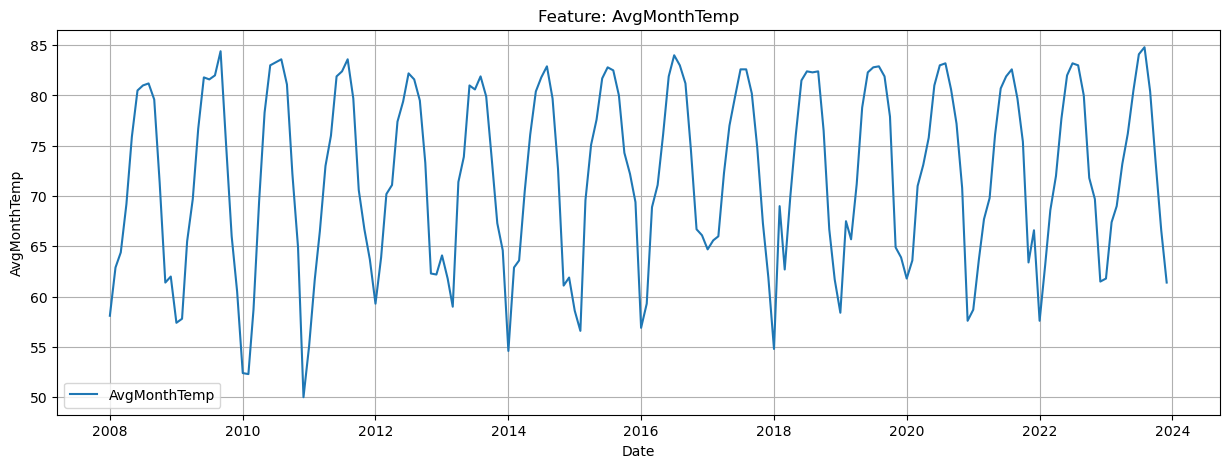

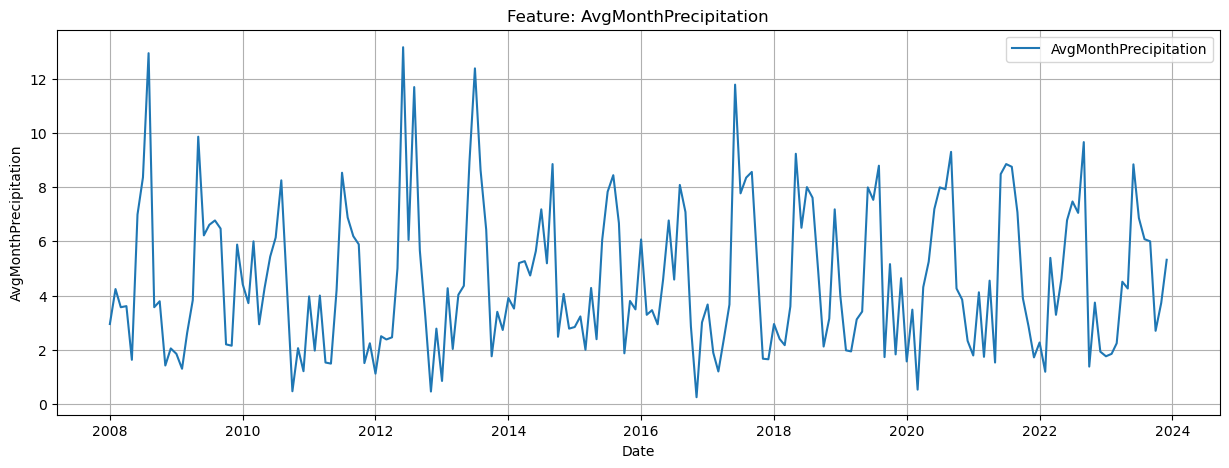

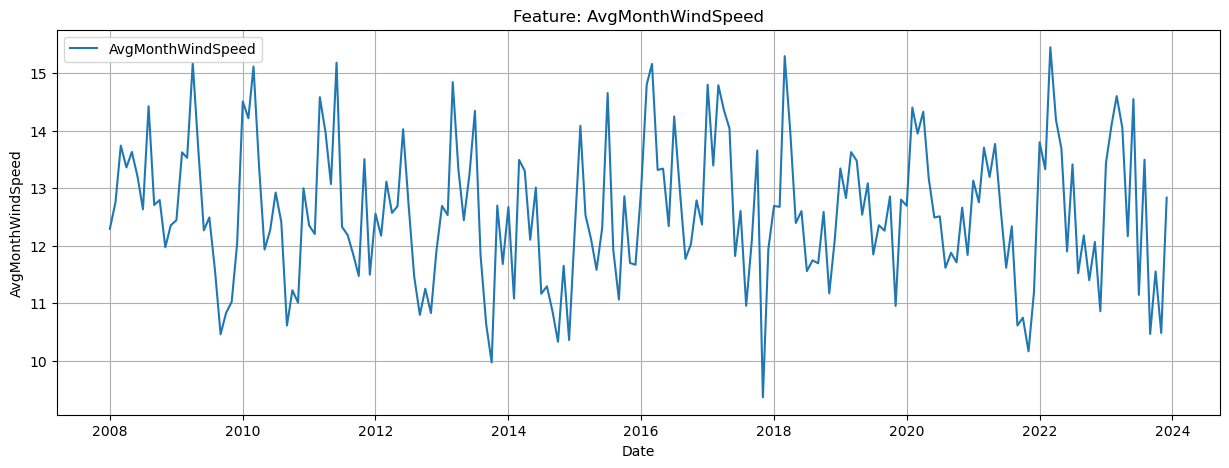

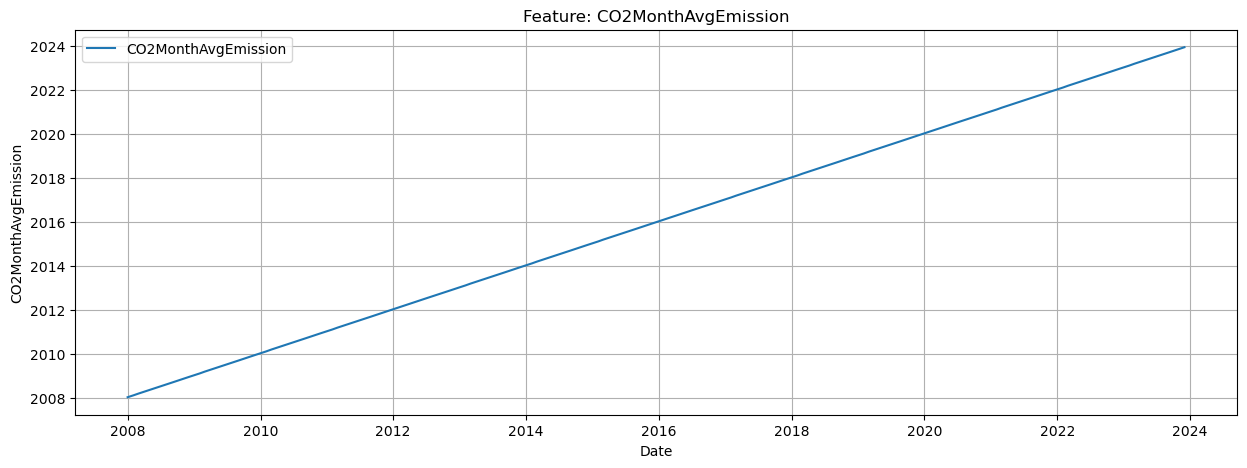

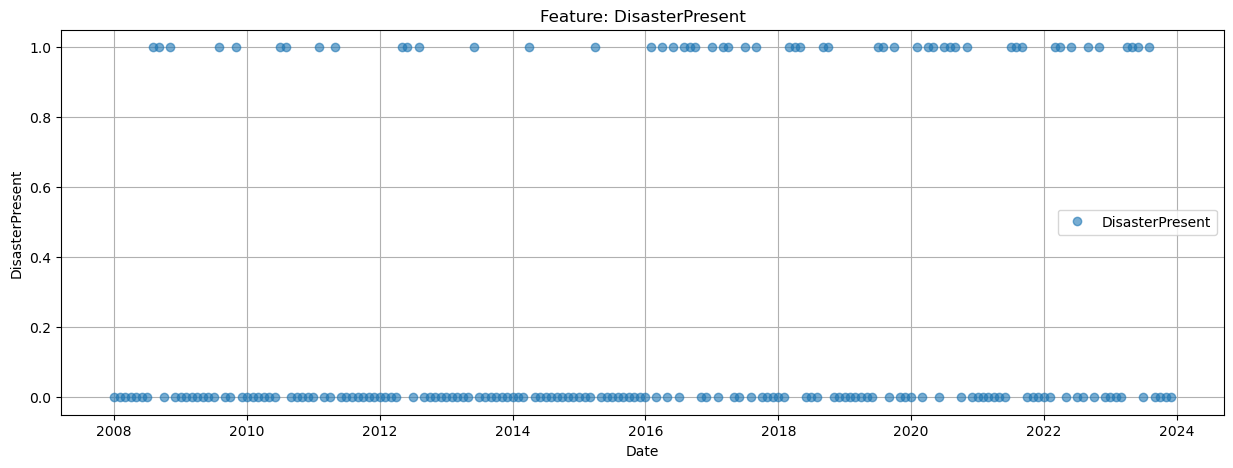

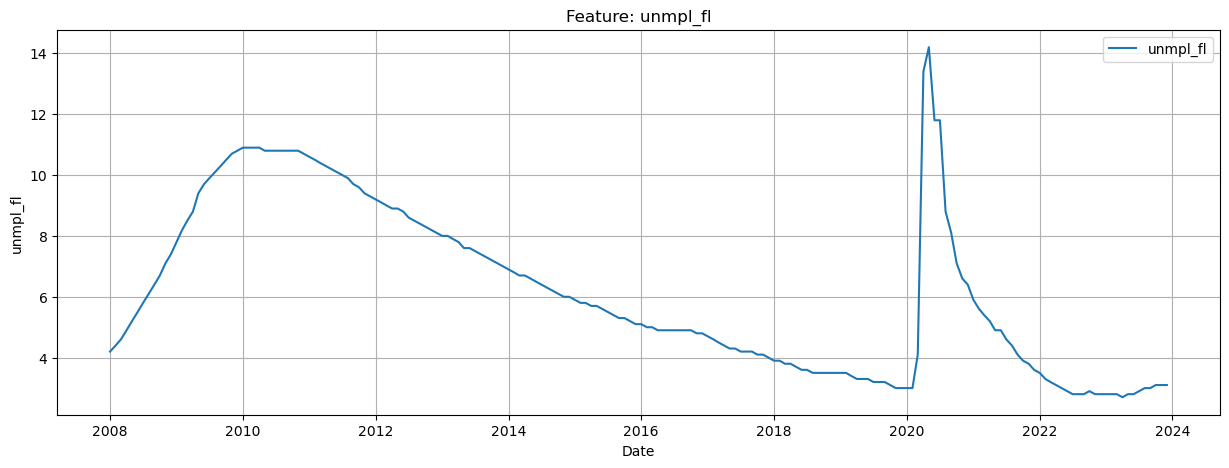

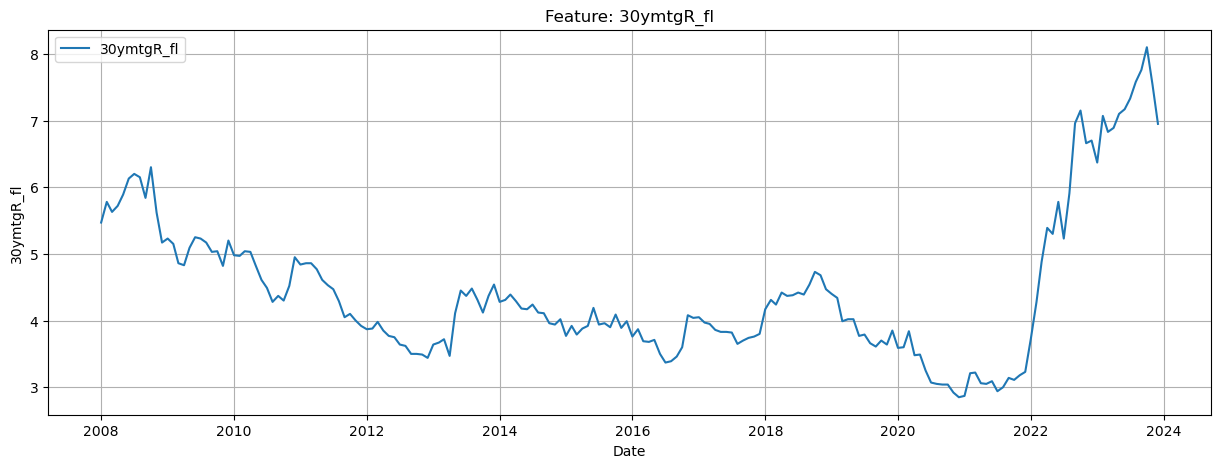

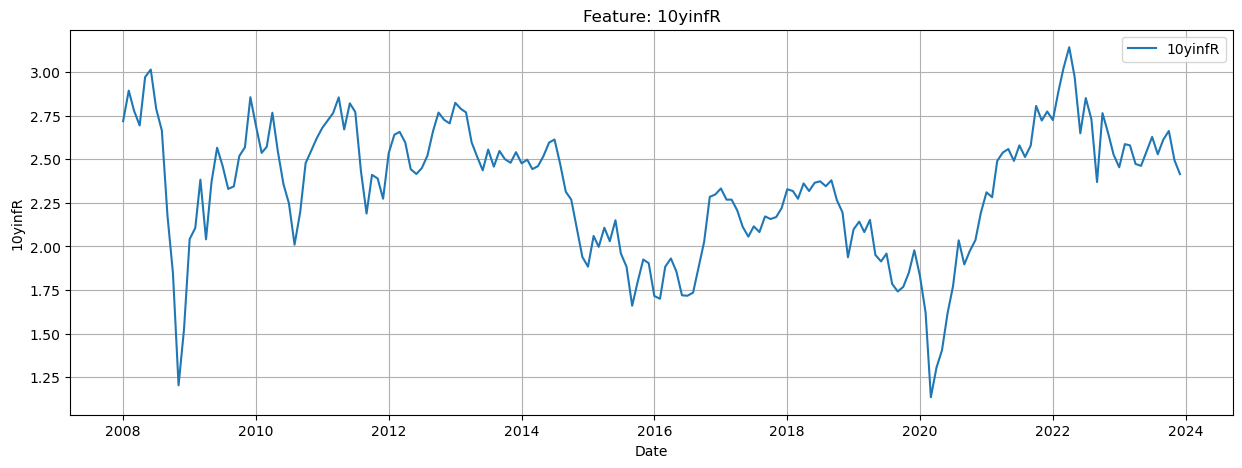

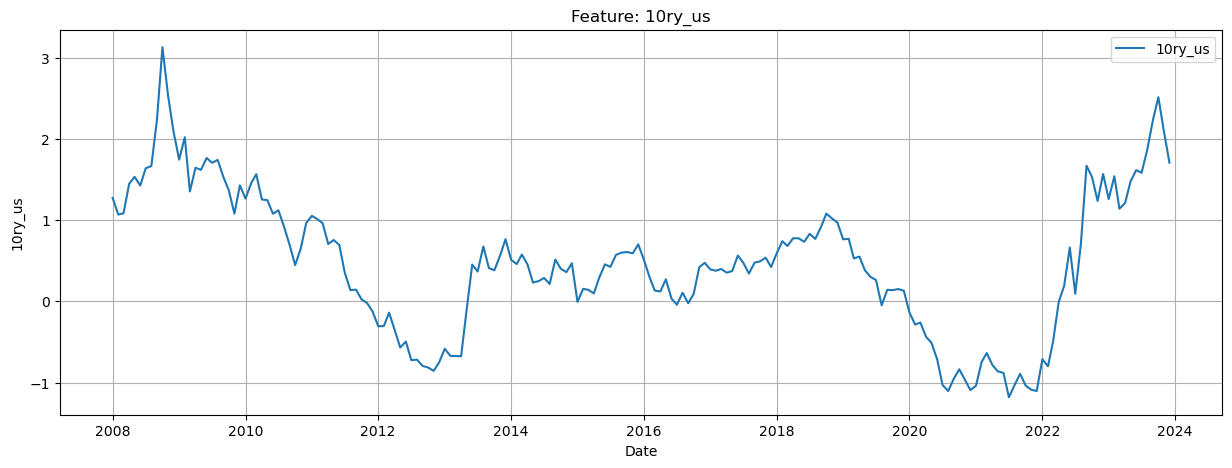

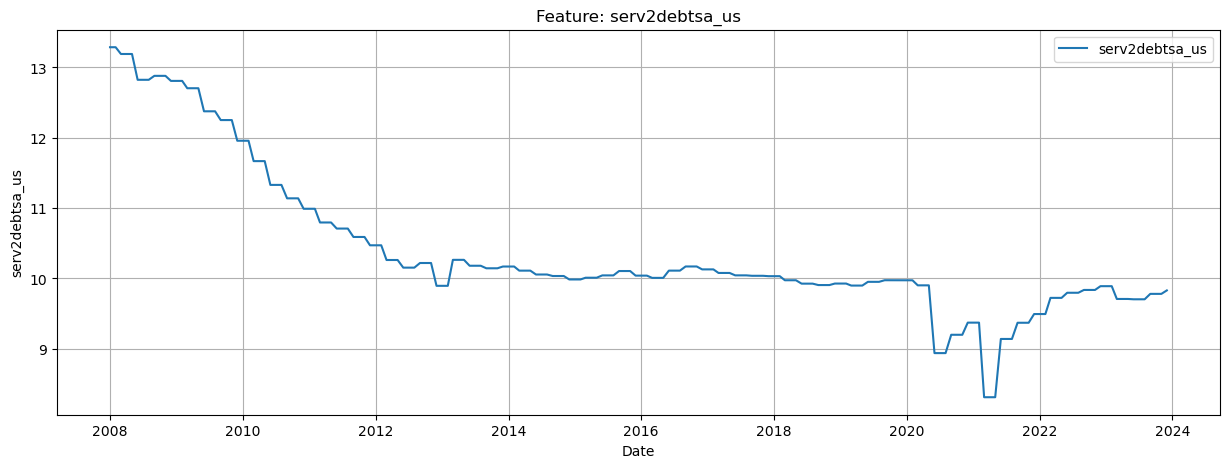

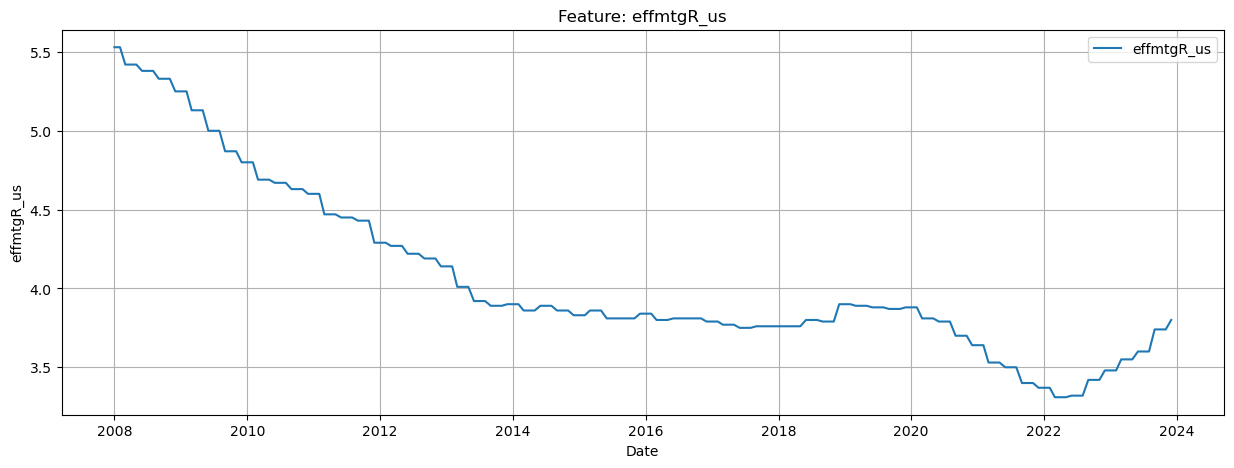

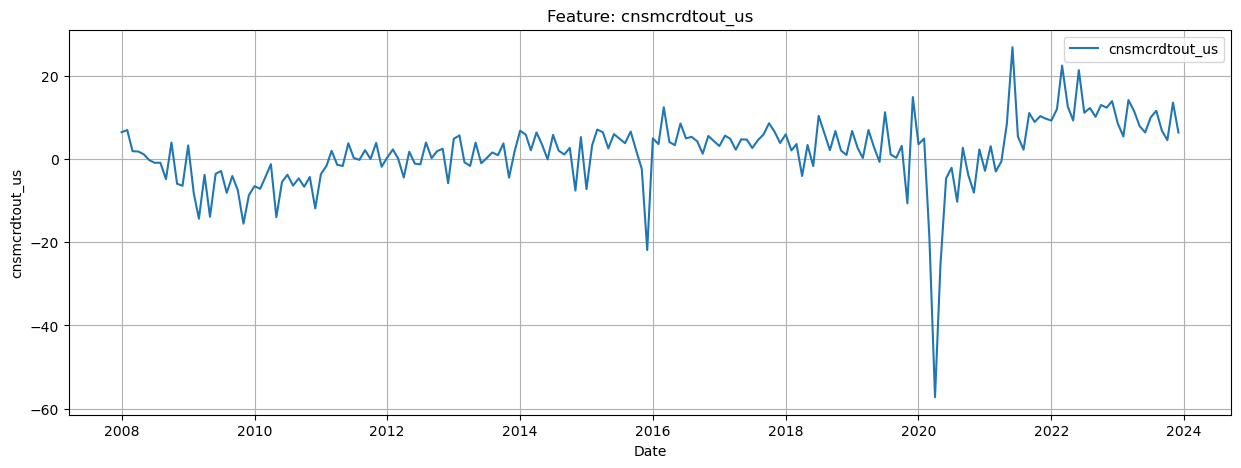

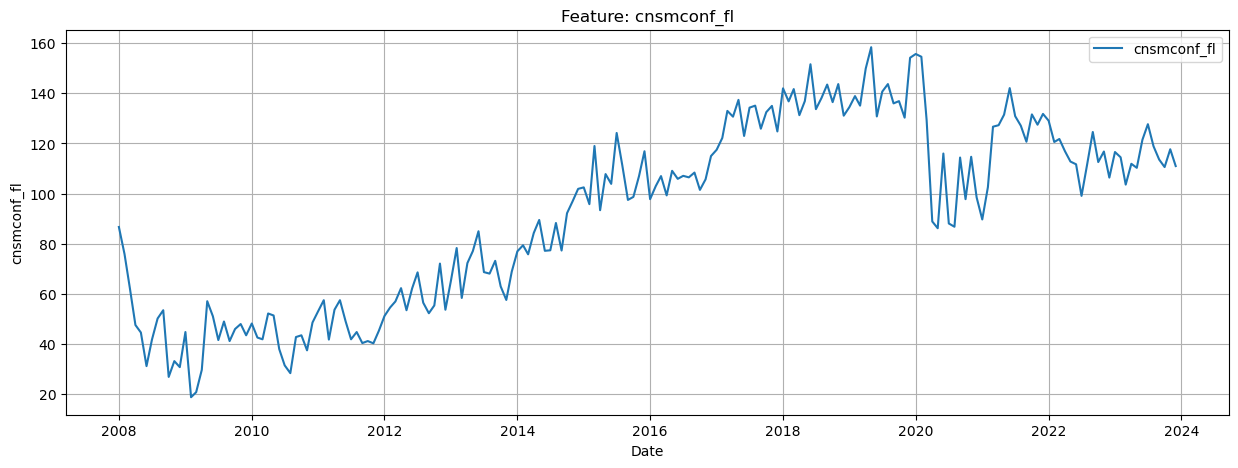

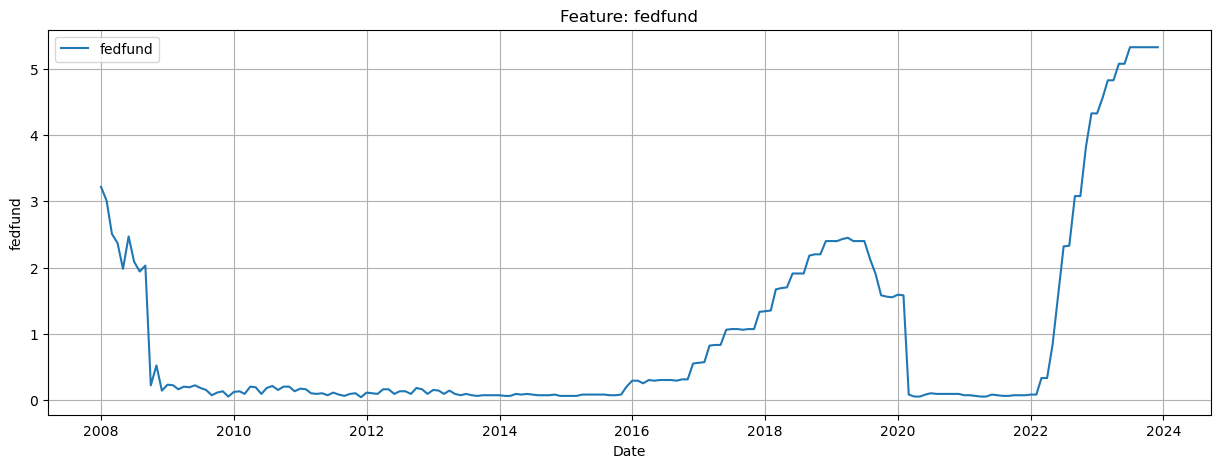

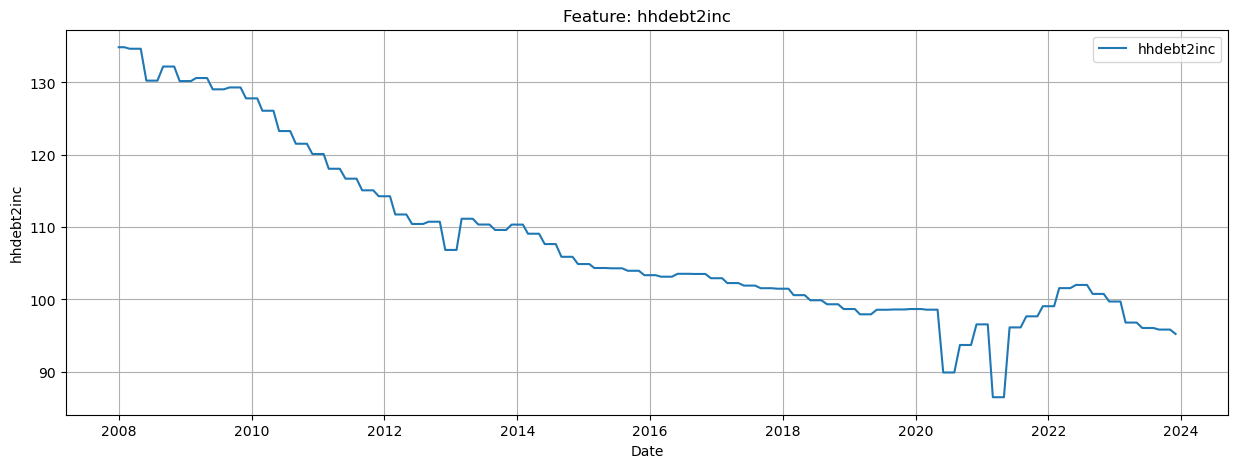

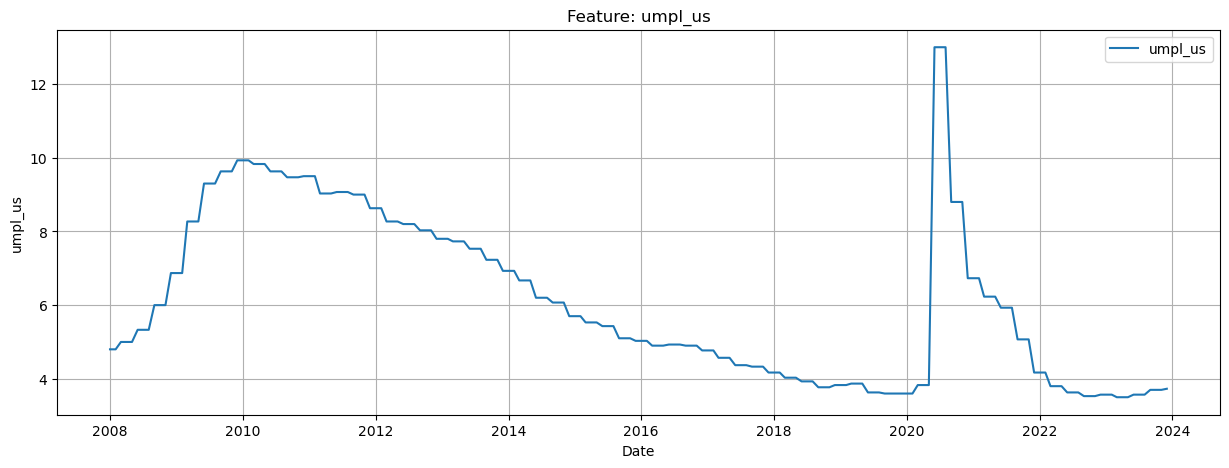

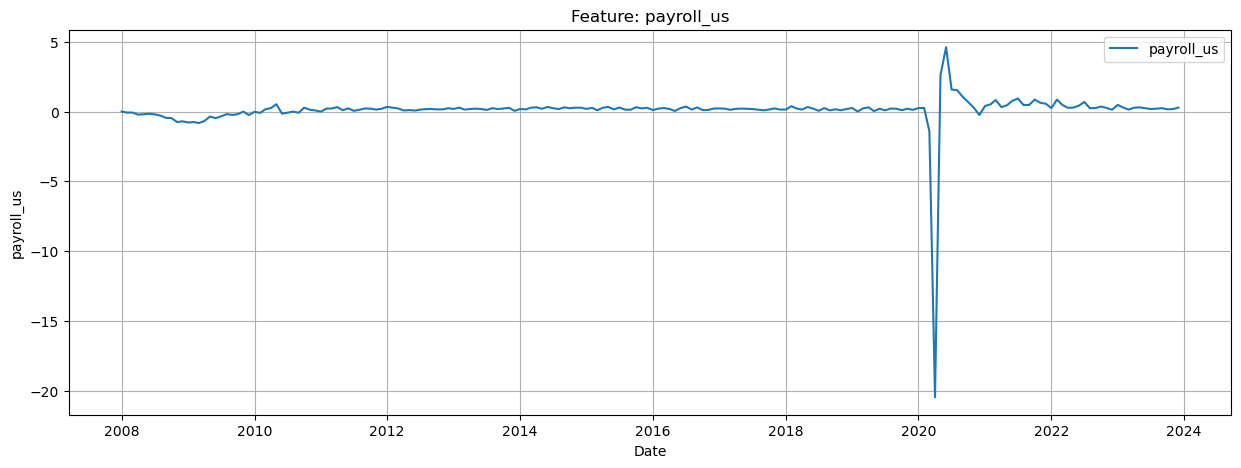

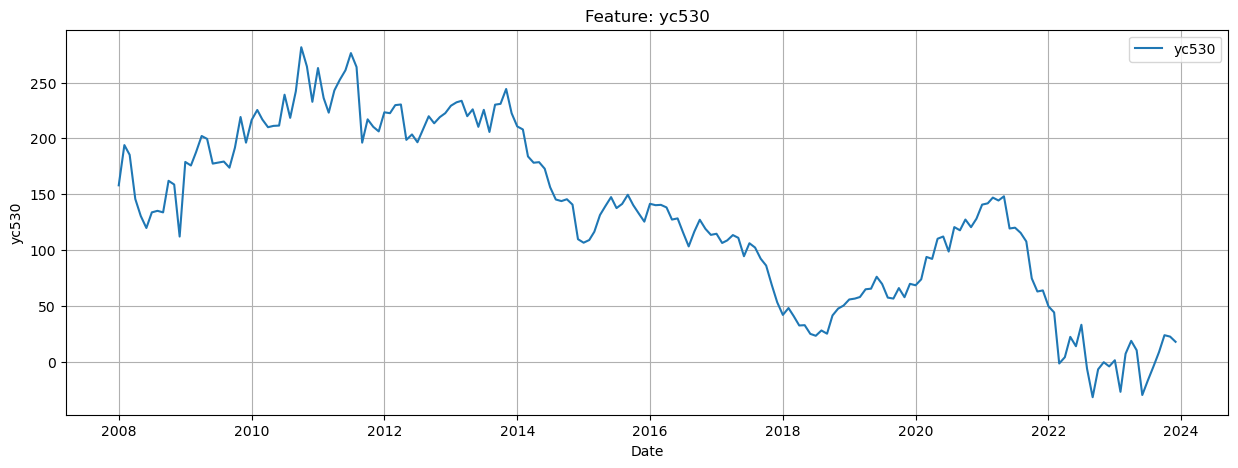

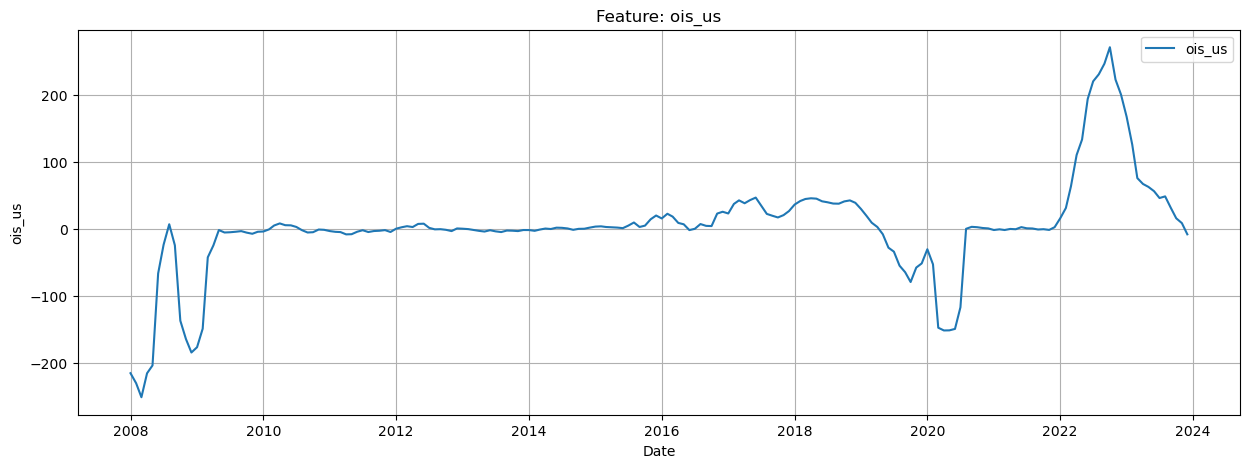

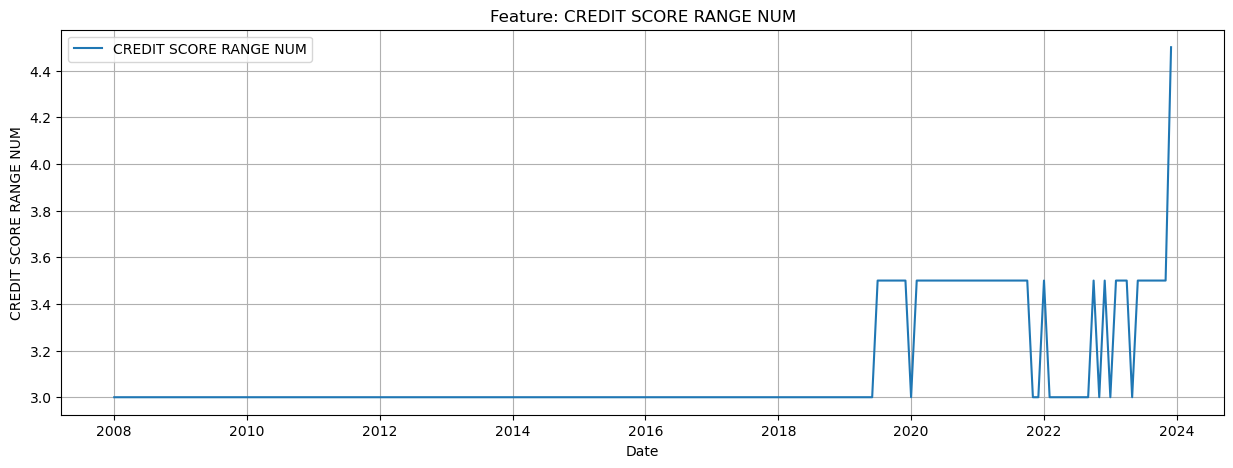

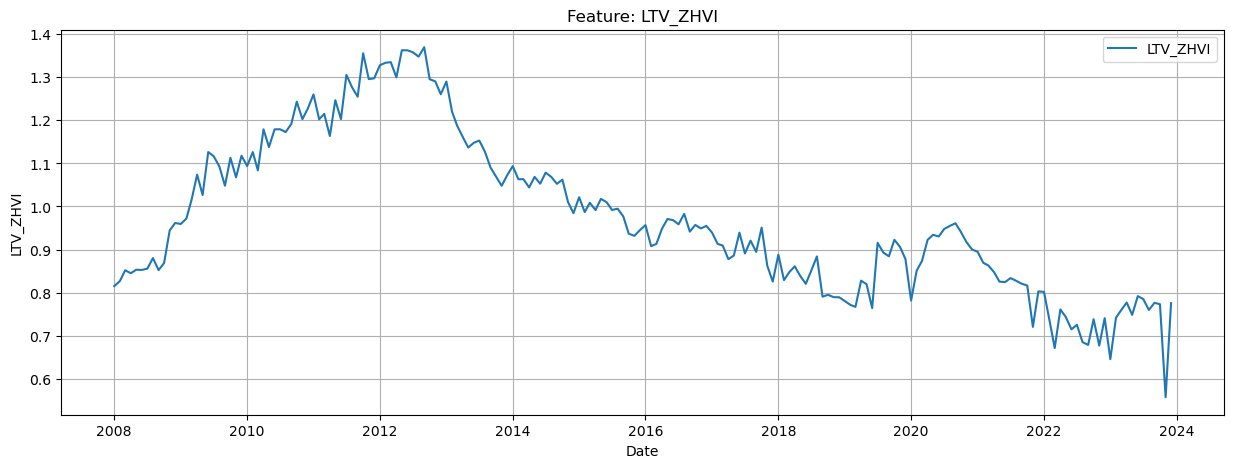

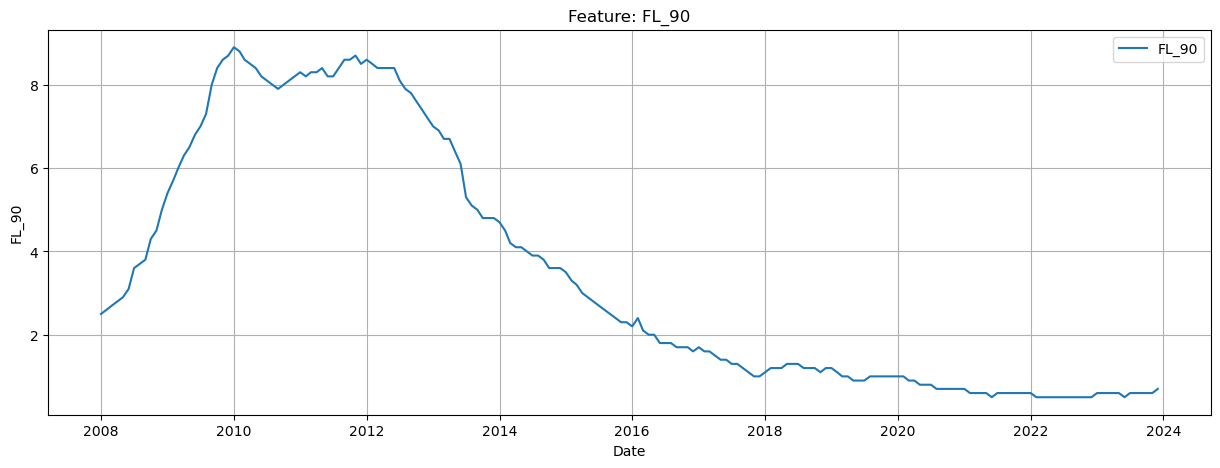

In [133]:
# Excluded columns (non-numeric or irrelevant for plotting)
exclude_columns = ['weather_Month', 'Date.1', 'Date.2']

# Features to plot as dot charts (e.g., categorical or discrete features)
dot_features = ['DisasterPresent']

# Example usage (ensure `data` is preprocessed and indexed by Date)
plot_features(data, exclude_columns, dot_features)

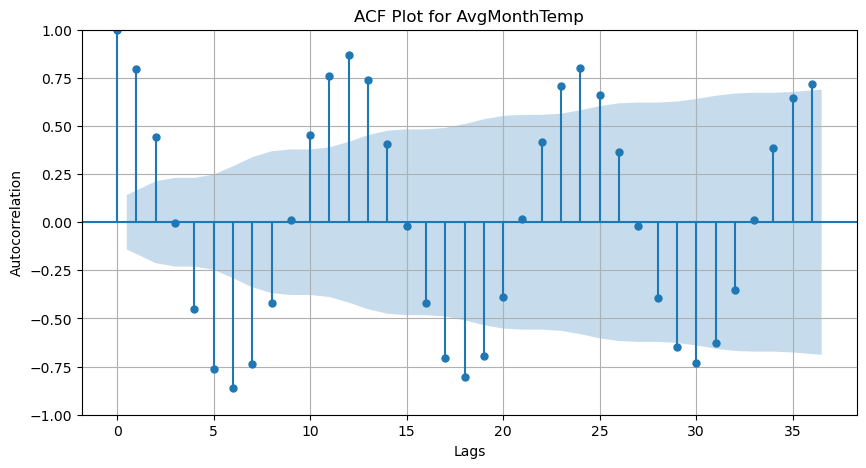

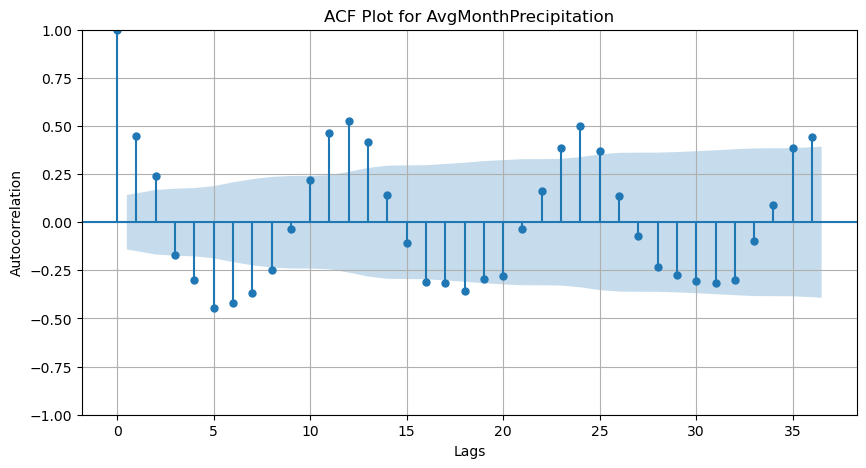

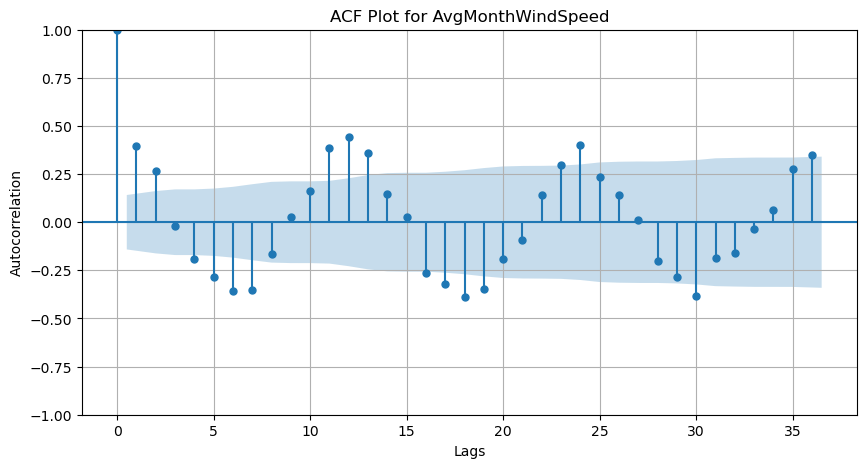

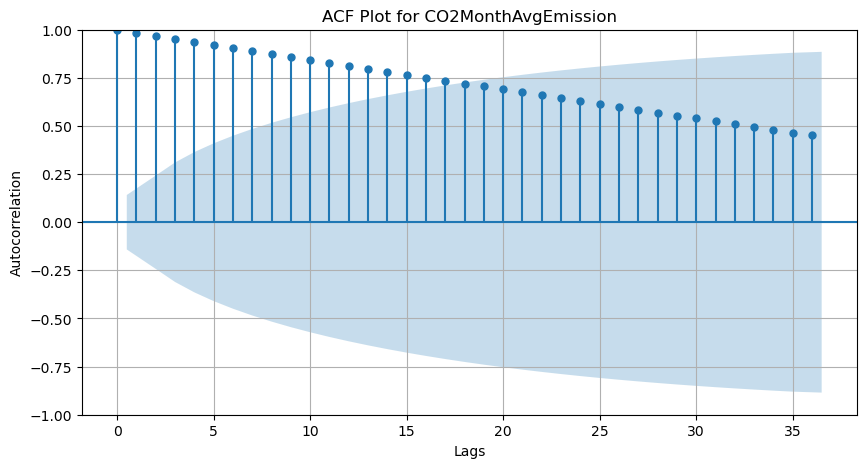

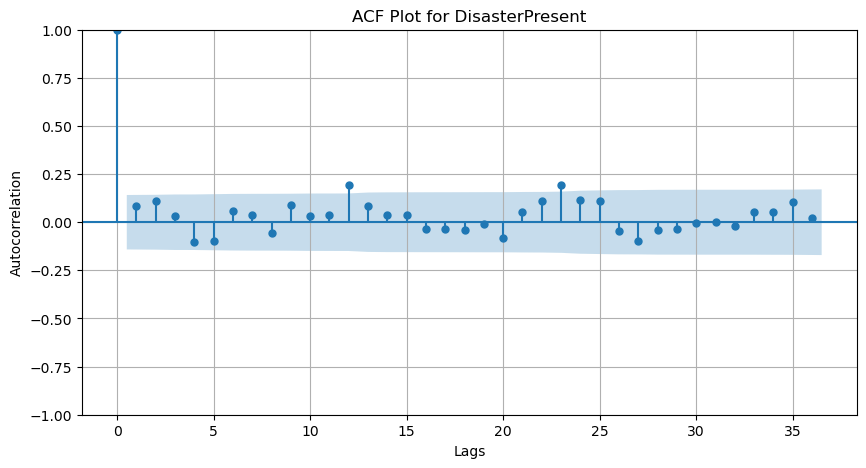

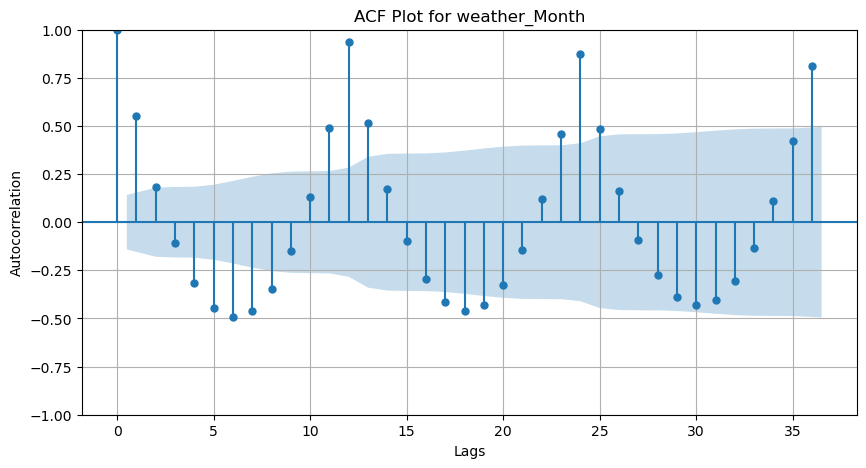

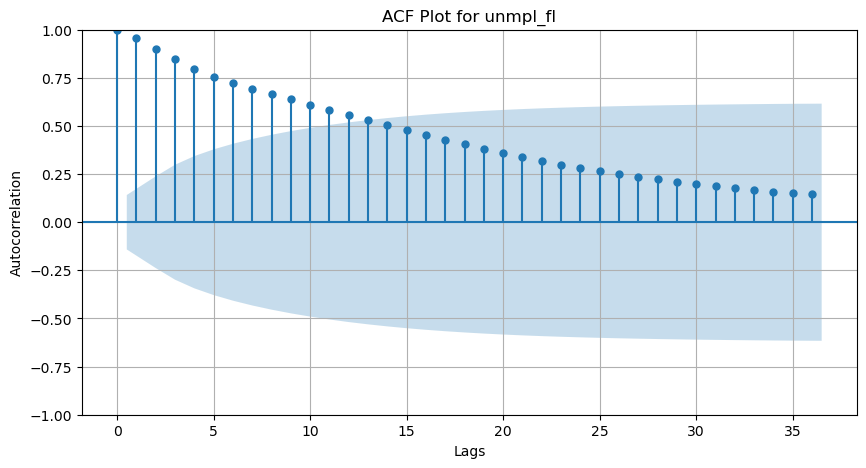

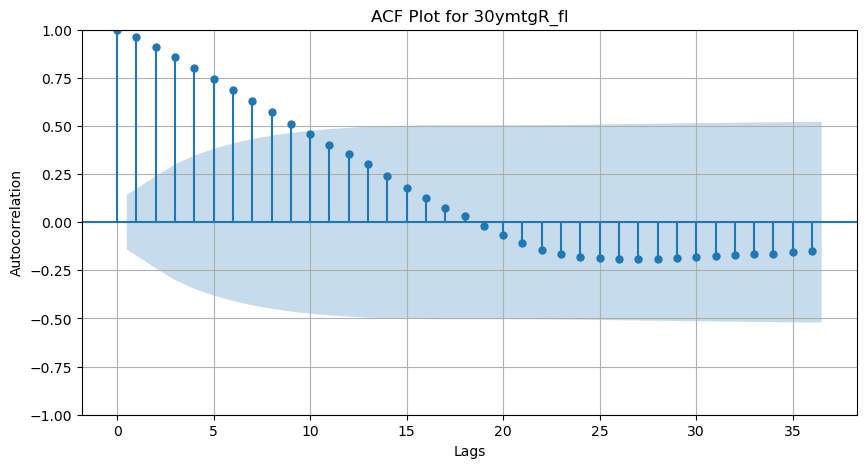

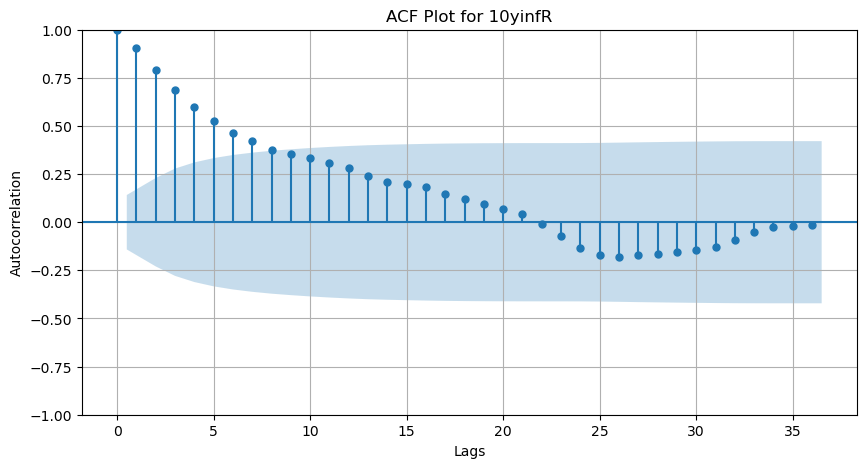

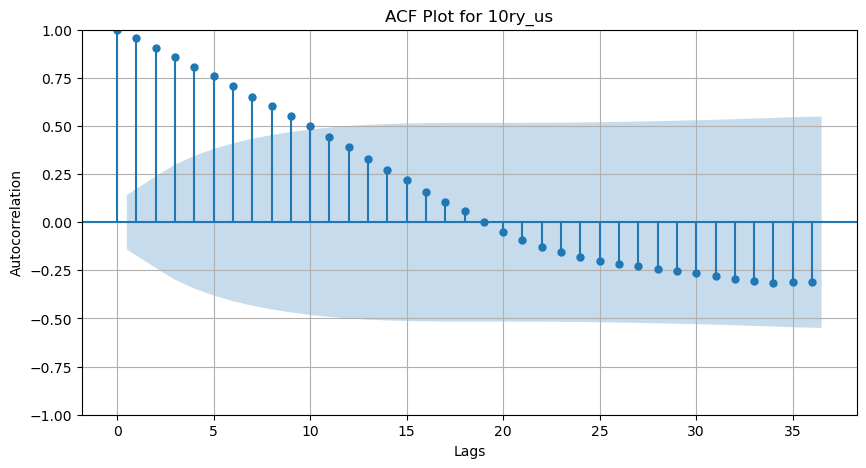

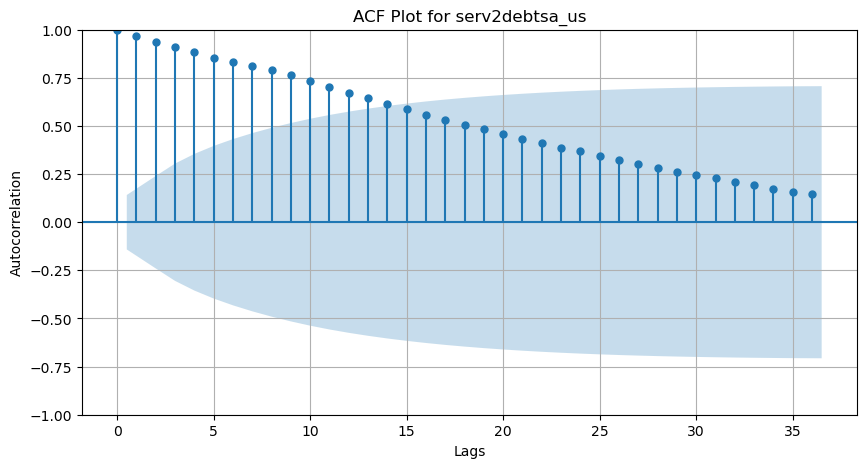

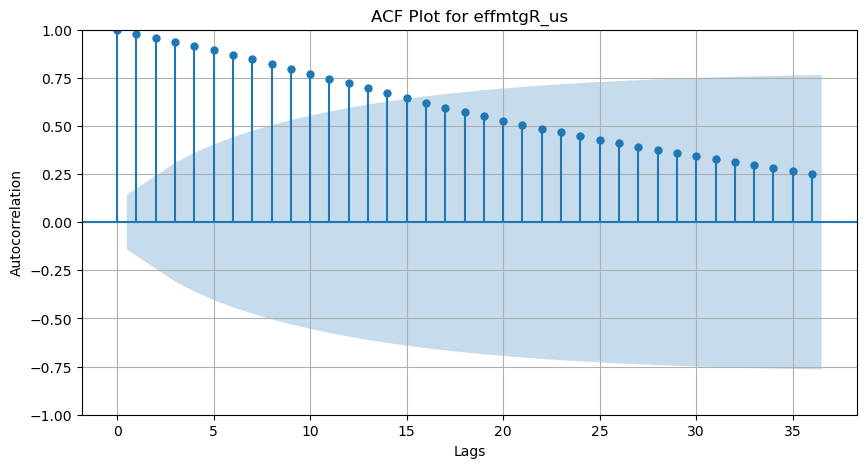

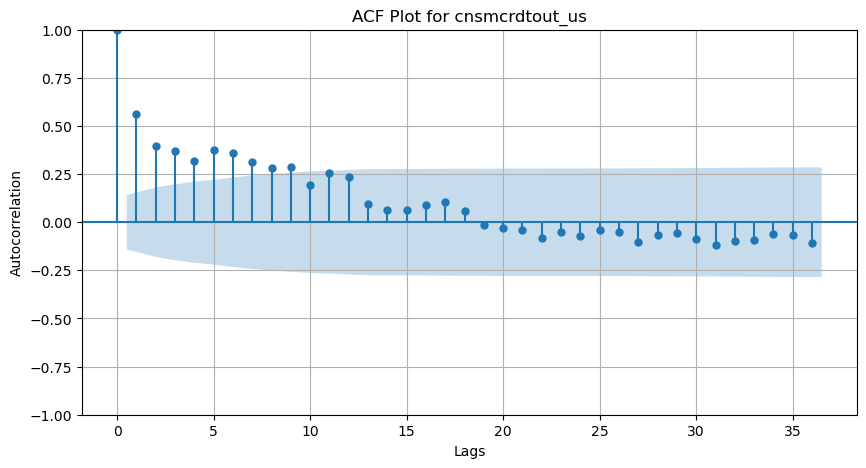

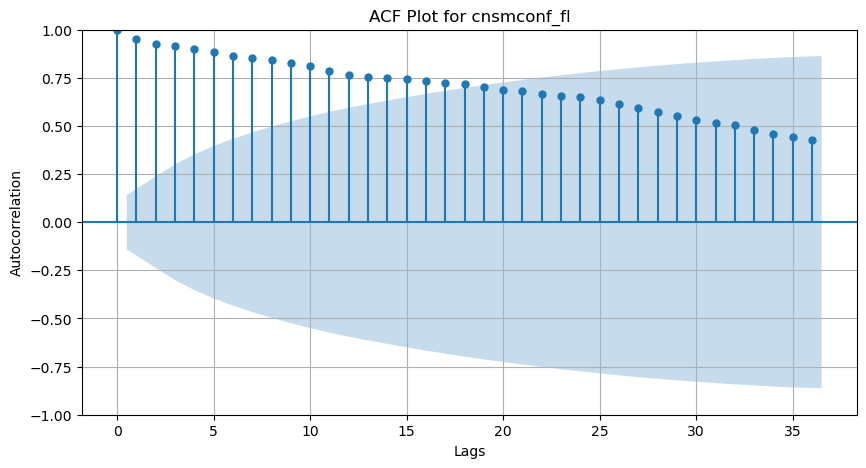

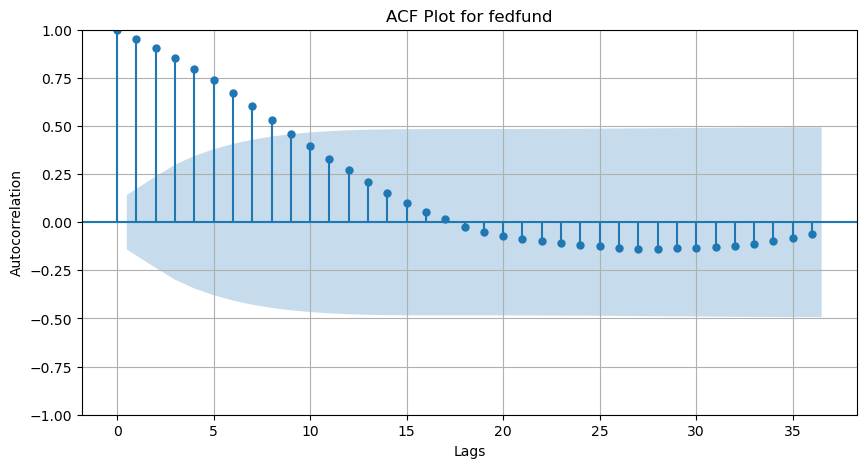

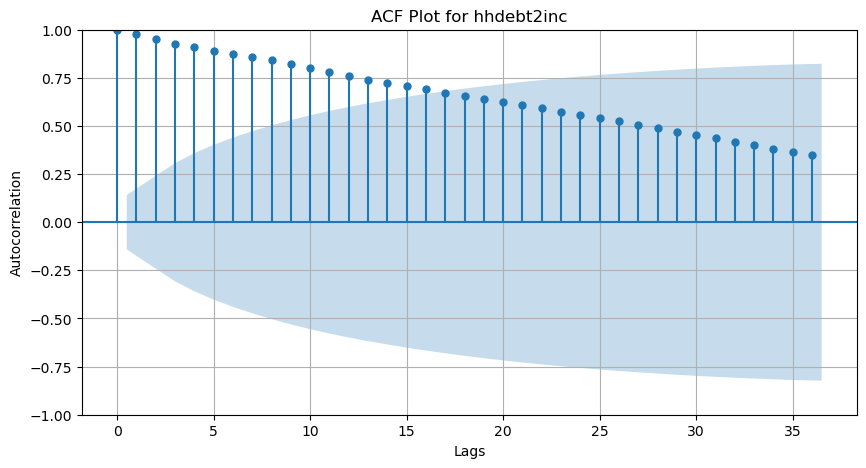

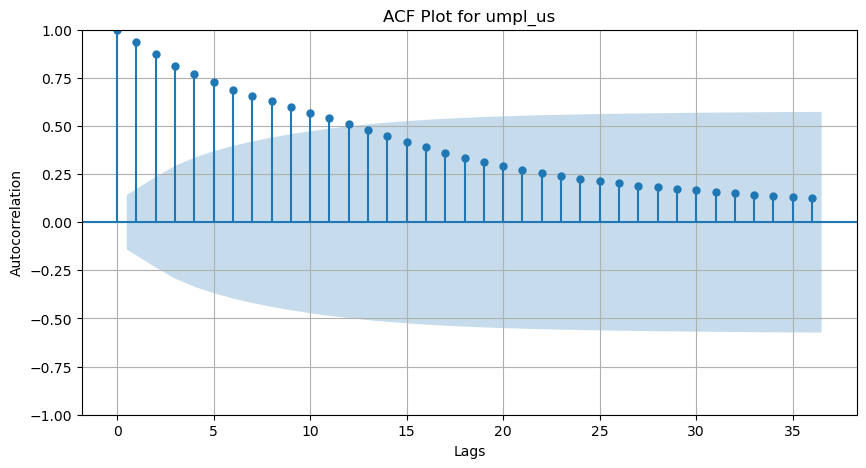

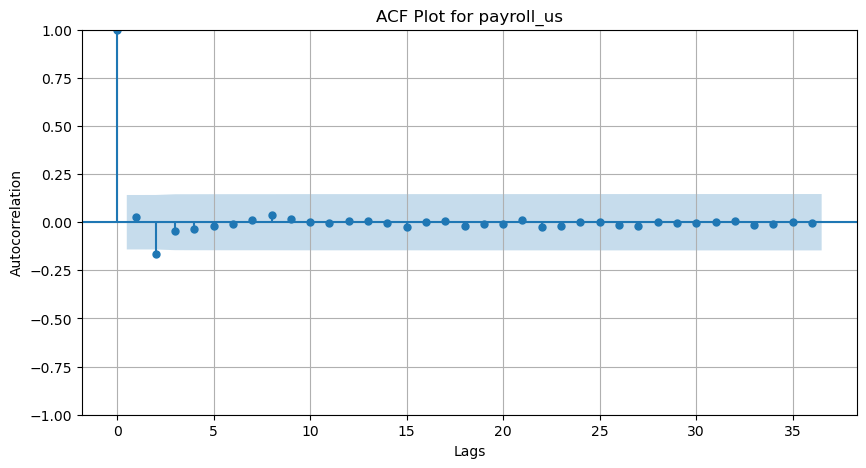

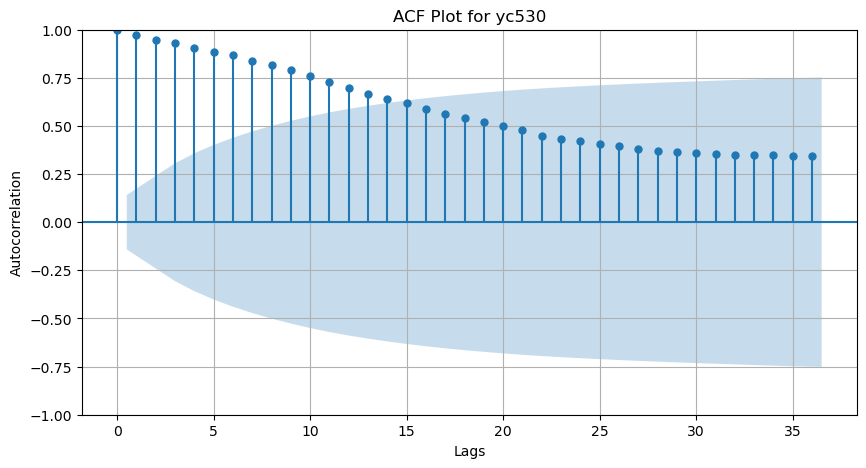

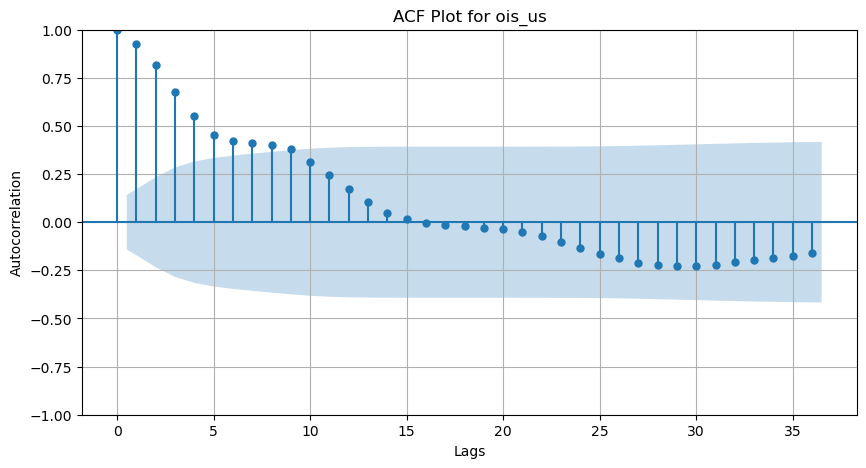

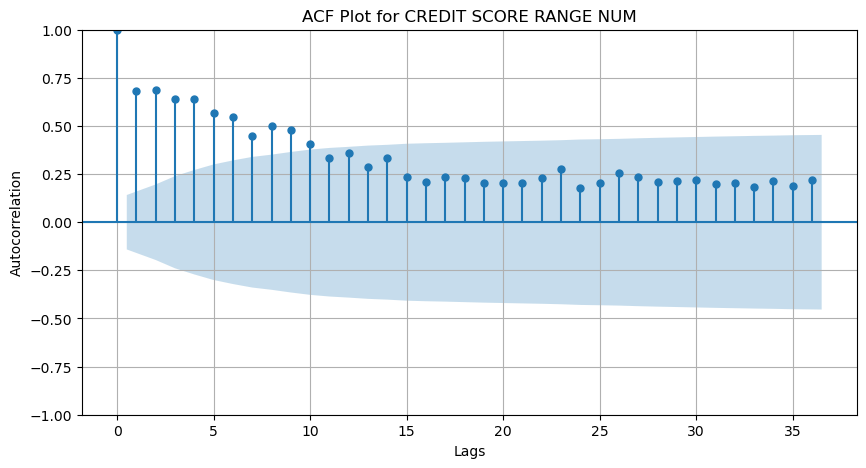

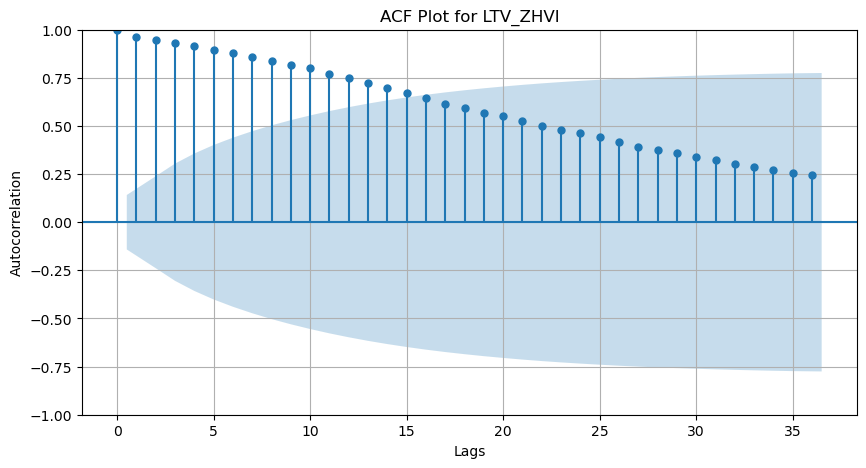

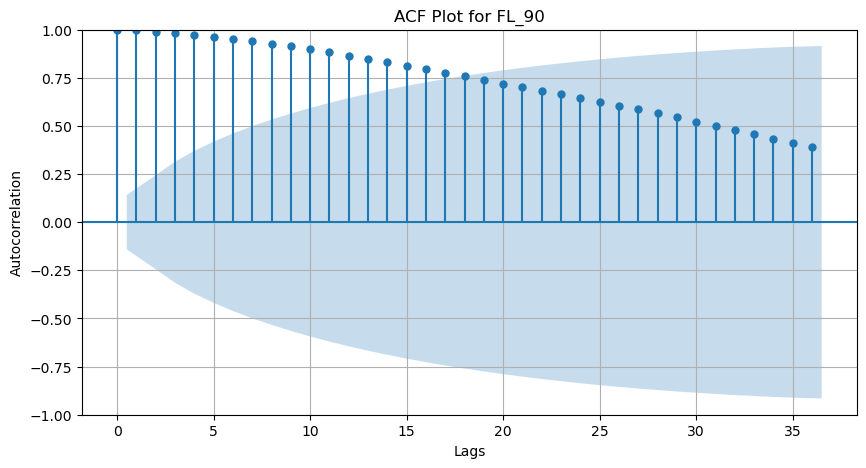

In [125]:
# Example usage:
plot_acf_dataframe(data, lags=36)
# plot_pacf_dataframe(features, lags=20)




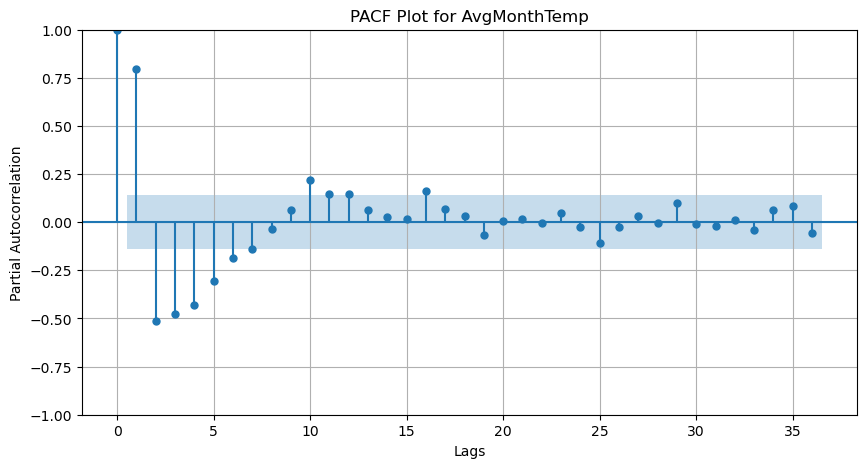

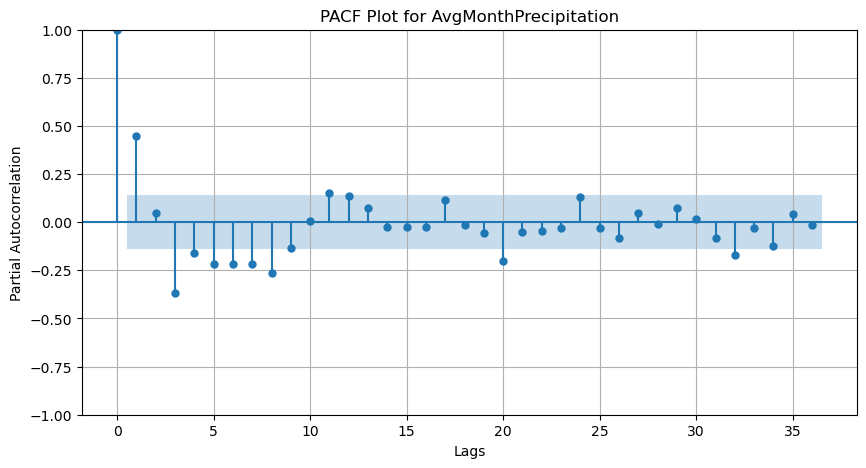

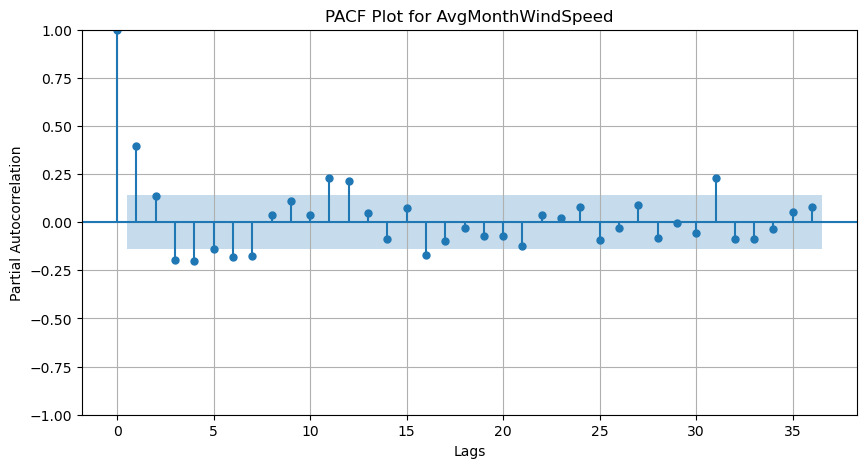

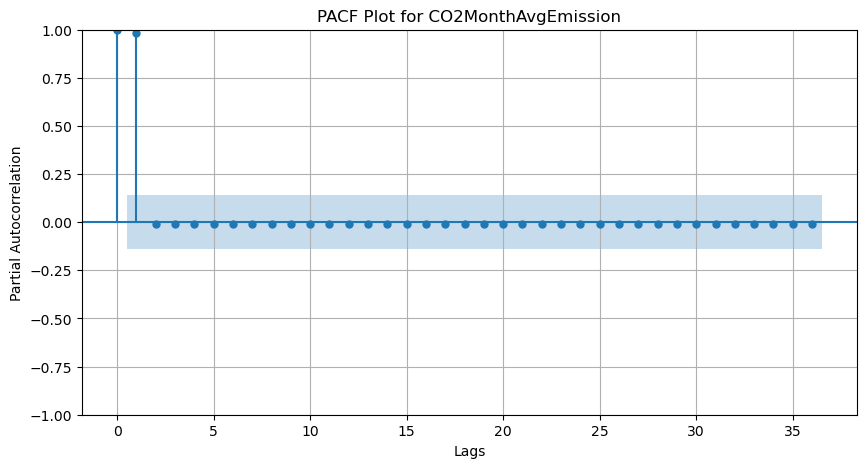

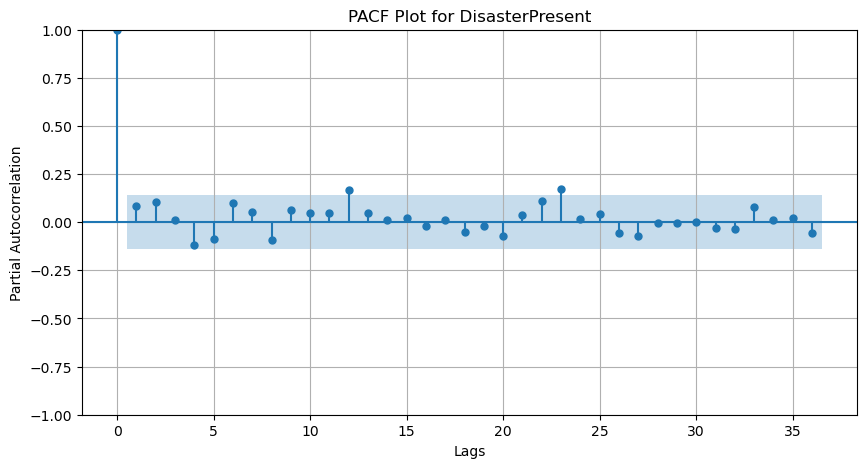

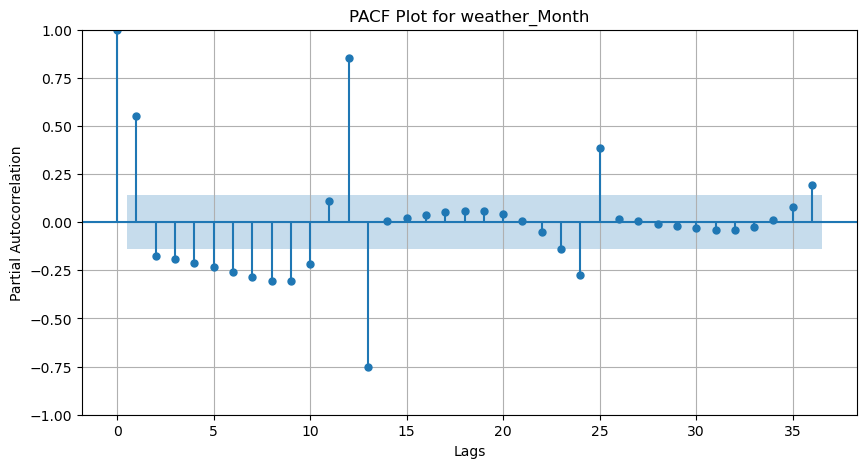

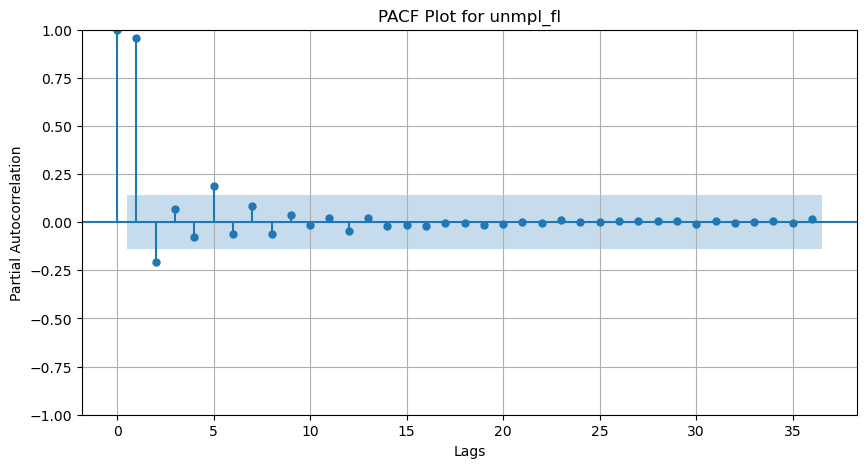

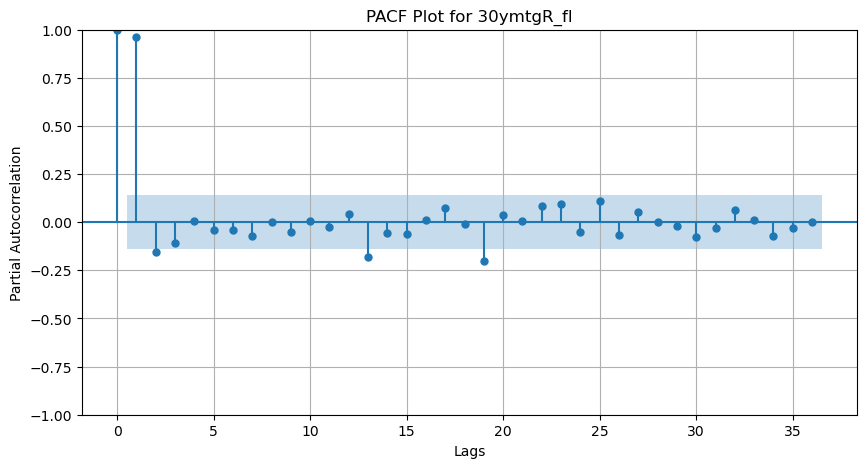

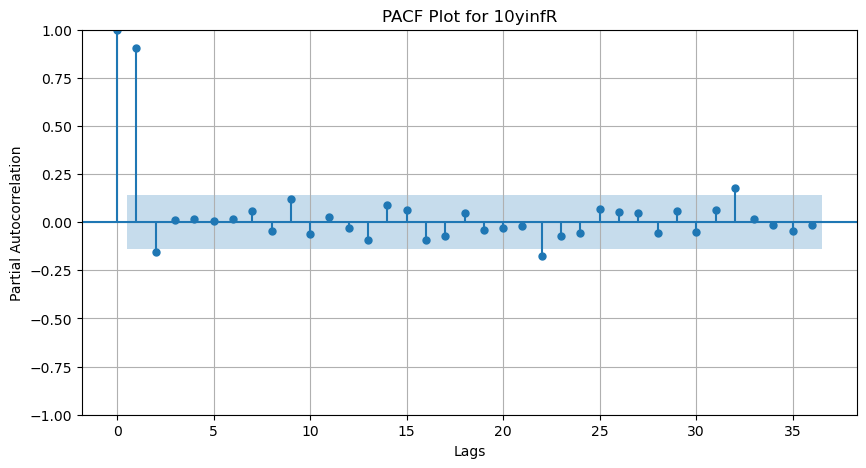

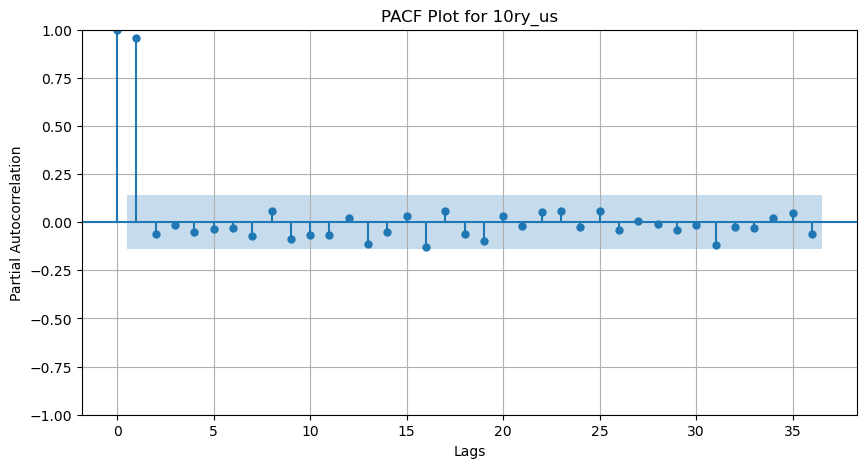

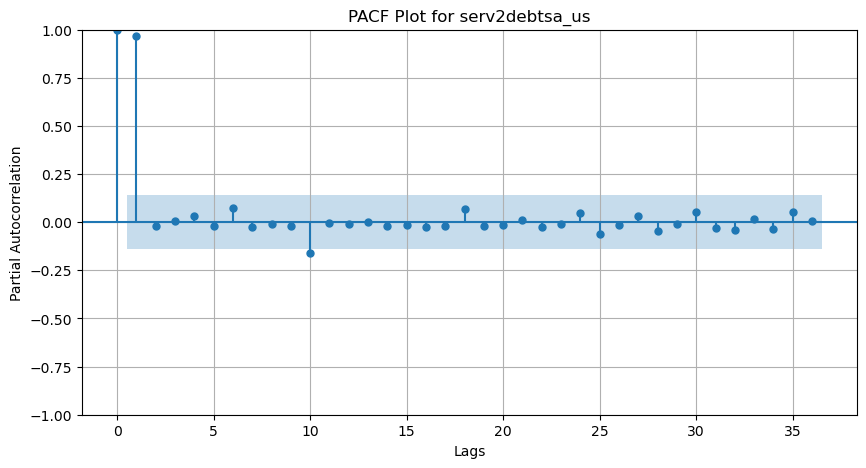

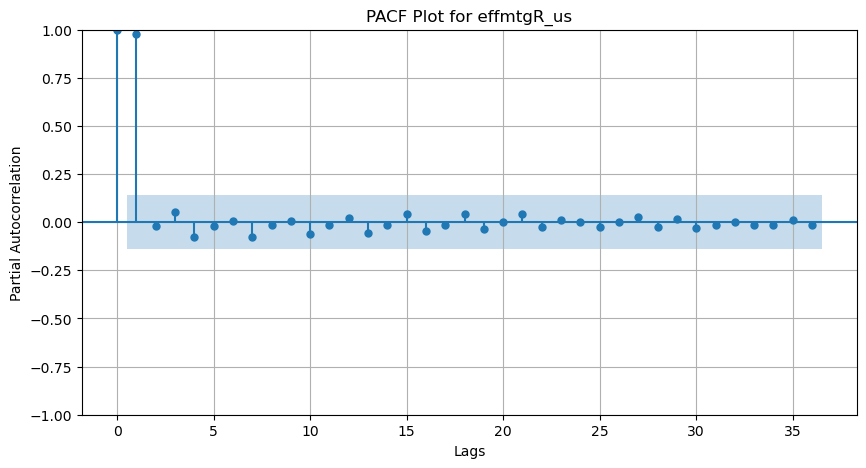

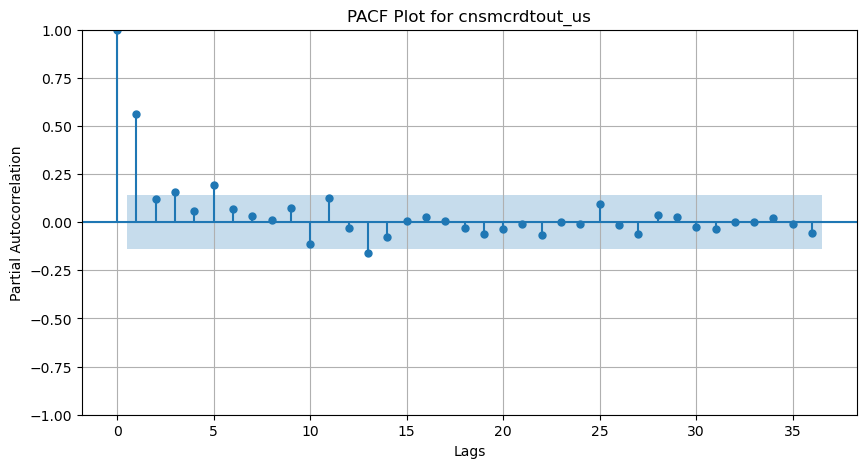

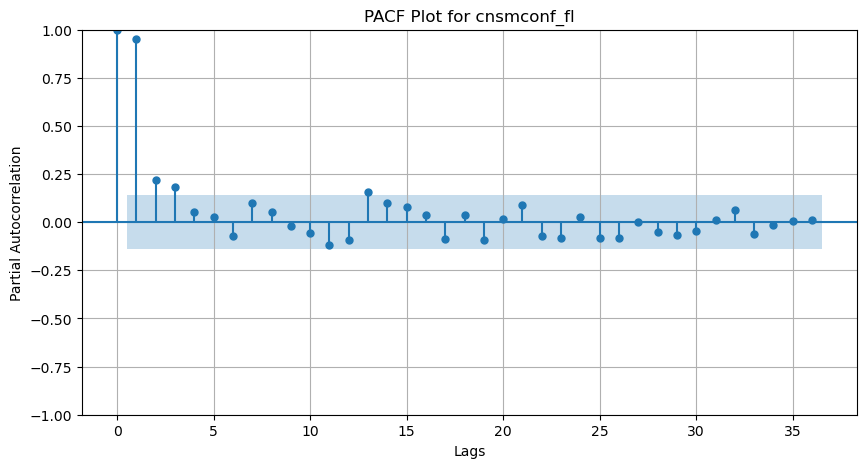

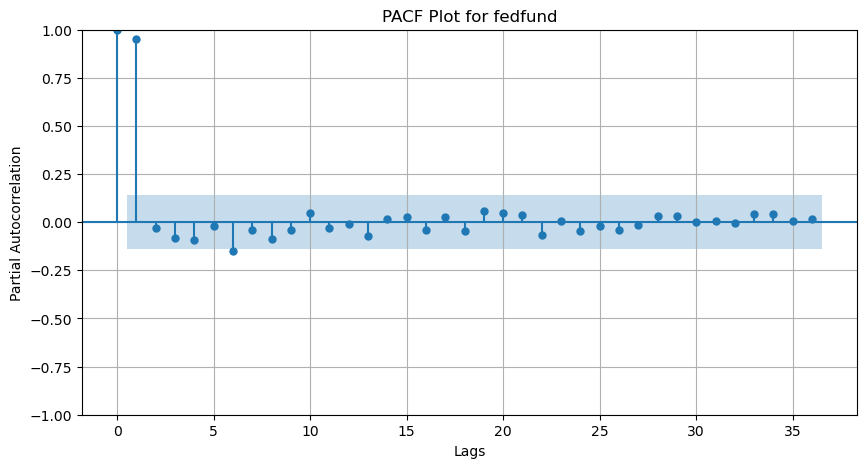

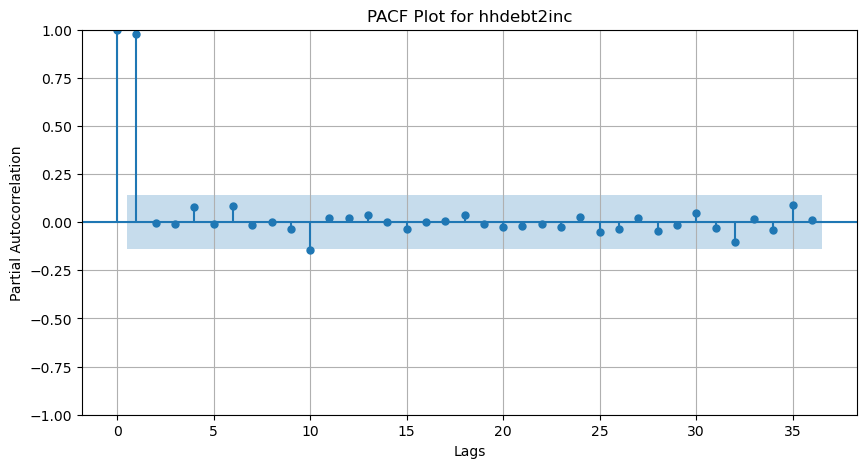

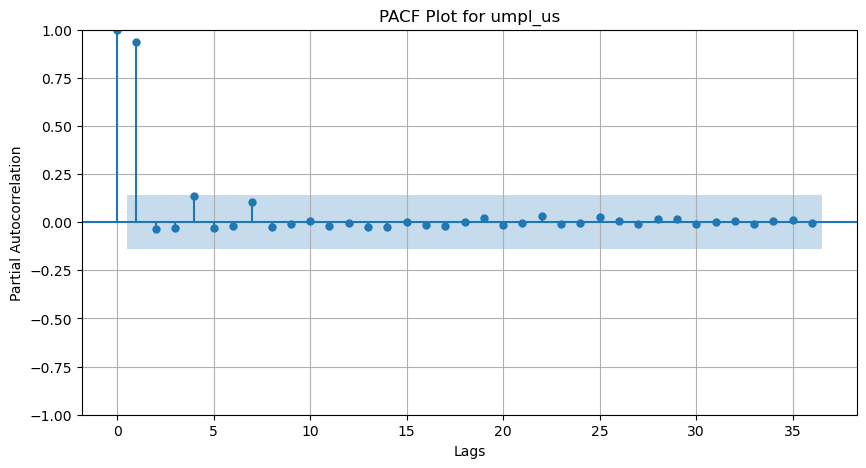

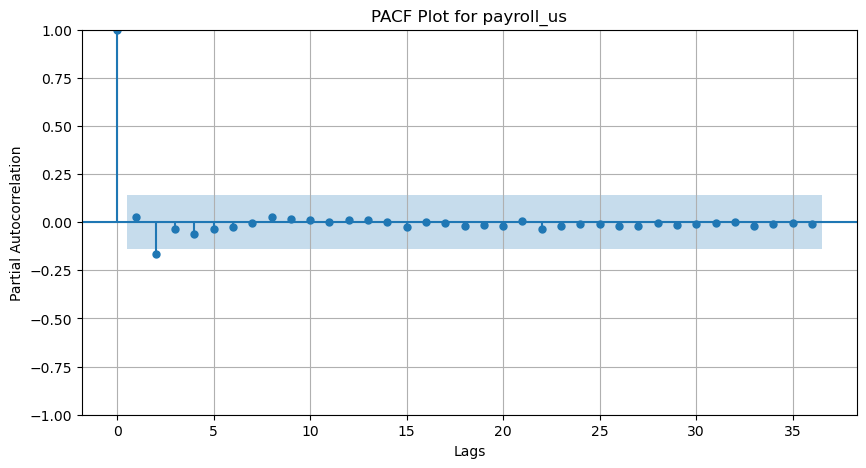

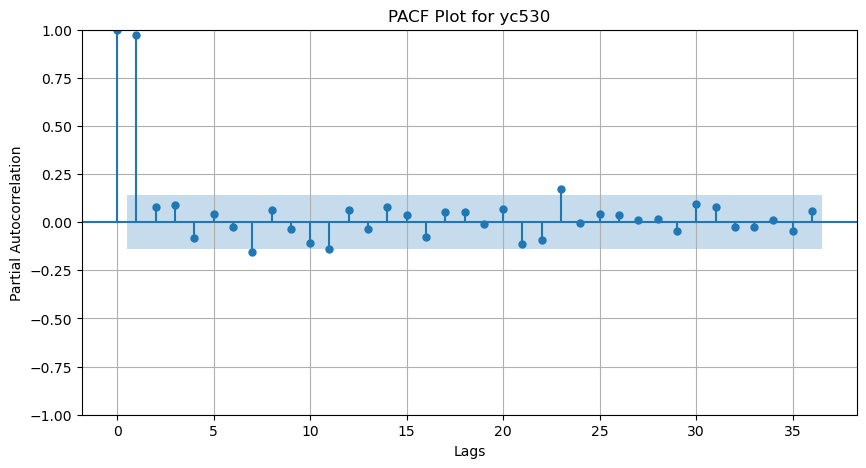

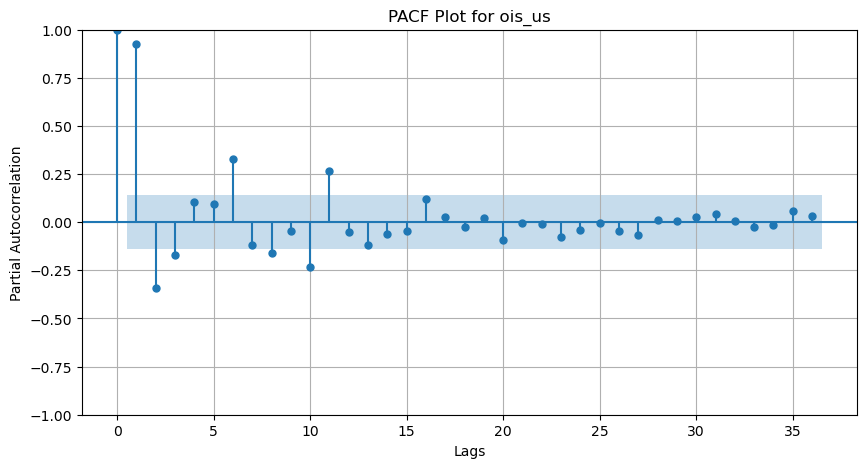

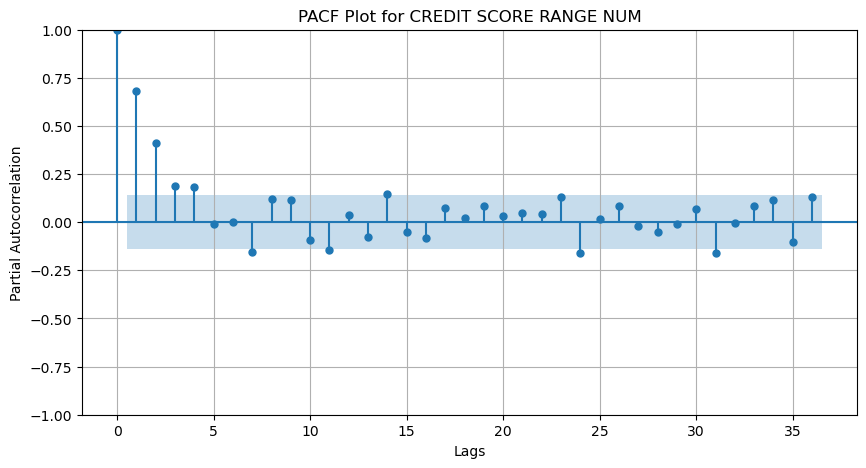

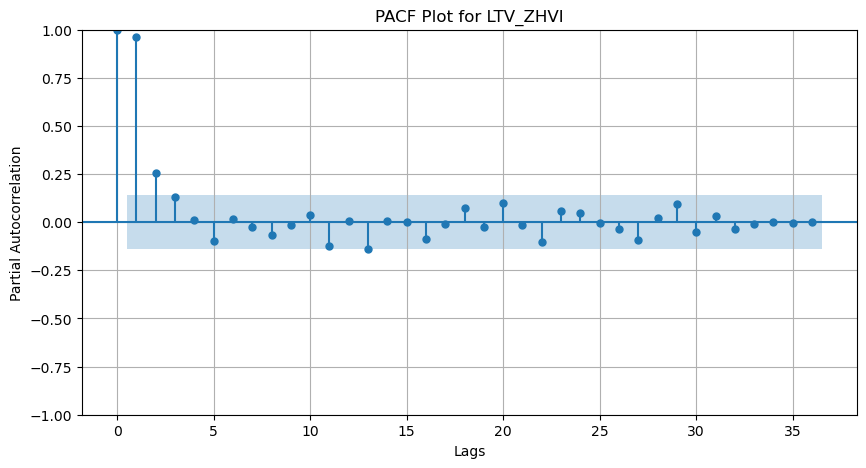

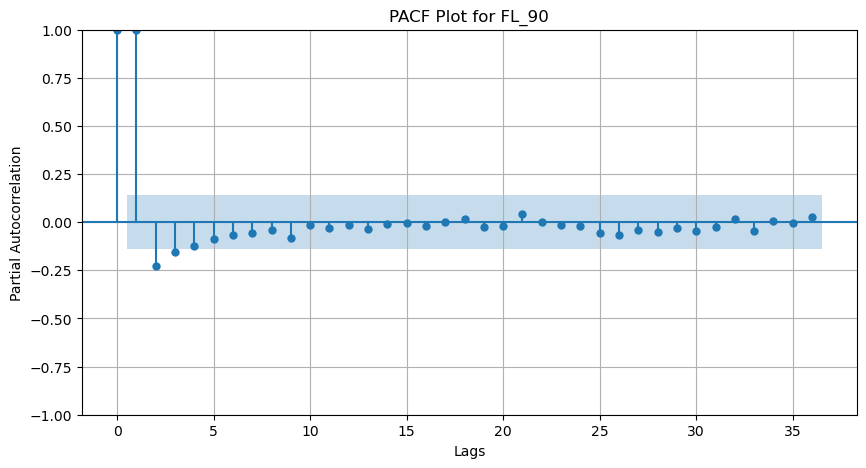

In [129]:
plot_pacf_dataframe(data, lags=36)

In [7]:
features.columns

Index(['AvgMonthTemp', 'AvgMonthPrecipitation', 'AvgMonthWindSpeed',
       'CO2MonthAvgEmission', 'DisasterPresent', 'weather_Month', 'Date.1',
       'unmpl_fl', '30ymtgR_fl', '10yinfR', '10ry_us', 'serv2debtsa_us',
       'effmtgR_us', 'cnsmcrdtout_us', 'cnsmconf_fl', 'fedfund', 'hhdebt2inc',
       'umpl_us', 'payroll_us', 'yc530', 'ois_us', 'Date.2',
       'CREDIT SCORE RANGE NUM', 'LTV_ZHVI'],
      dtype='object')

In [8]:
features = features[[
    'CREDIT SCORE RANGE NUM', 'LTV_ZHVI', 'unmpl_fl', '30ymtgR_fl', '10yinfR',
    '10ry_us', 'serv2debtsa_us', 'effmtgR_us', 'cnsmcrdtout_us', 'cnsmconf_fl',
    'hhdebt2inc', 'payroll_us', 'yc530', 'ois_us', 'AvgMonthTemp', 'AvgMonthPrecipitation', 
     'AvgMonthWindSpeed', 'CO2MonthAvgEmission', 'DisasterPresent', 'weather_Month']]

In [9]:
target

Date
2008-01-01    2.5
2008-02-01    2.6
2008-03-01    2.7
2008-04-01    2.8
2008-05-01    2.9
             ... 
2023-08-01    0.6
2023-09-01    0.6
2023-10-01    0.6
2023-11-01    0.6
2023-12-01    0.7
Name: FL_90, Length: 192, dtype: float64

In [10]:
features.head()

,CREDIT SCORE RANGE NUM,LTV_ZHVI,unmpl_fl,30ymtgR_fl,10yinfR,10ry_us,serv2debtsa_us,effmtgR_us,cnsmcrdtout_us,cnsmconf_fl,hhdebt2inc,payroll_us,yc530,ois_us,AvgMonthTemp,AvgMonthPrecipitation,AvgMonthWindSpeed,CO2MonthAvgEmission,DisasterPresent,weather_Month
Date,,,,,,,,,,,,,,,,,,,,
2008-01-01,3.0,0.815062,4.2,5.47,2.7175,1.2729,13.288177,5.53,6.40,86.7,134.87,0.001,157.952,-215.00,58.1,2.95,12.293548,2008.0417,0,1
2008-02-01,3.0,0.826807,4.4,5.78,2.8928,1.0680,13.288177,5.53,6.91,75.9,134.87,-0.071,193.975,-230.00,62.9,4.24,12.755172,2008.1250,0,2
2008-03-01,3.0,0.851926,4.6,5.63,2.7780,1.0835,13.191871,5.42,1.83,62.5,134.66,-0.070,185.267,-250.85,64.4,3.57,13.738710,2008.2083,0,3
2008-04-01,3.0,0.844988,4.9,5.72,2.6929,1.4466,13.191871,5.42,1.76,47.6,134.66,-0.219,145.747,-215.10,69.2,3.61,13.360000,2008.2917,0,4
2008-05-01,3.0,0.853223,5.2,5.89,2.9700,1.5320,13.191871,5.42,1.11,44.6,134.66,-0.190,130.564,-203.40,75.9,1.63,13.629032,2008.3750,0,5


In [11]:
time_steps = 12
# Create squence function
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)
X_with_weather = features.values
y = target.values
# For data with weather features
data_with_weather = np.hstack([X_with_weather, y.reshape(-1, 1)])
X_with_weather_seq, y_with_weather_seq = create_sequences(data_with_weather, time_steps)
X_train_with_weather, X_test_with_weather, y_train_with, y_test_with = train_test_split(X_with_weather_seq, y_with_weather_seq, test_size=0.2, random_state=42)

# Normalize the data
scaler_with_weather = StandardScaler().fit(X_train_with_weather.reshape(-1, X_train_with_weather.shape[2]))
X_train_with_weather = scaler_with_weather.transform(X_train_with_weather.reshape(-1, X_train_with_weather.shape[2])).reshape(X_train_with_weather.shape)
X_test_with_weather = scaler_with_weather.transform(X_test_with_weather.reshape(-1, X_test_with_weather.shape[2])).reshape(X_test_with_weather.shape)

In [12]:
len(X_with_weather), len(y)

(192, 192)

In [13]:
data_with_weather

array([[ 3.        ,  0.81506188,  4.2       , ...,  0.        ,
         1.        ,  2.5       ],
       [ 3.        ,  0.82680744,  4.4       , ...,  0.        ,
         2.        ,  2.6       ],
       [ 3.        ,  0.85192635,  4.6       , ...,  0.        ,
         3.        ,  2.7       ],
       ...,
       [ 3.5       ,  0.77303055,  3.1       , ...,  0.        ,
        10.        ,  0.6       ],
       [ 3.5       ,  0.55712221,  3.1       , ...,  0.        ,
        11.        ,  0.6       ],
       [ 4.5       ,  0.77540485,  3.1       , ...,  0.        ,
        12.        ,  0.7       ]])

In [14]:
# Create feature names
feature_names = [f"Feature_{i+1}" for i in range(X_with_weather.shape[1])]
columns = feature_names + ["Target"]

# Convert to DataFrame
df_with_weather = pd.DataFrame(data_with_weather, columns=columns)

In [15]:
df_with_weather

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Target
0,3.0,0.815062,4.2,5.47,2.7175,1.2729,13.288177,5.53,6.40,86.7,...,0.001,157.952,-215.00,58.1,2.95,12.293548,2008.0417,0.0,1.0,2.5
1,3.0,0.826807,4.4,5.78,2.8928,1.0680,13.288177,5.53,6.91,75.9,...,-0.071,193.975,-230.00,62.9,4.24,12.755172,2008.1250,0.0,2.0,2.6
2,3.0,0.851926,4.6,5.63,2.7780,1.0835,13.191871,5.42,1.83,62.5,...,-0.070,185.267,-250.85,64.4,3.57,13.738710,2008.2083,0.0,3.0,2.7
3,3.0,0.844988,4.9,5.72,2.6929,1.4466,13.191871,5.42,1.76,47.6,...,-0.219,145.747,-215.10,69.2,3.61,13.360000,2008.2917,0.0,4.0,2.8
4,3.0,0.853223,5.2,5.89,2.9700,1.5320,13.191871,5.42,1.11,44.6,...,-0.190,130.564,-203.40,75.9,1.63,13.629032,2008.3750,0.0,5.0,2.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,3.5,0.759816,3.0,7.58,2.5284,1.8658,9.703748,3.60,11.54,118.9,...,0.210,-4.419,48.90,84.8,6.08,13.493548,2023.6250,1.0,8.0,0.6
188,3.5,0.776375,3.0,7.76,2.6130,2.2286,9.780870,3.74,6.75,113.6,...,0.246,8.662,31.87,80.4,6.00,10.466667,2023.7083,0.0,9.0,0.6
189,3.5,0.773031,3.1,8.10,2.6614,2.5124,9.780870,3.74,4.48,110.6,...,0.165,23.774,16.19,73.4,2.70,11.551613,2023.7917,0.0,10.0,0.6
190,3.5,0.557122,3.1,7.54,2.4938,2.0871,9.780870,3.74,13.49,117.7,...,0.182,22.514,9.01,66.6,3.73,10.483333,2023.8750,0.0,11.0,0.6


In [16]:
# Define the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    return model

In [17]:
# Paths for saving the model and training history
model_path = './data/lstm_model_full3.keras'
history_path = './data/lstm_training_history3.pkl'

# Check if the model and history already exist
if os.path.exists(model_path) and os.path.exists(history_path):
    # Load the existing model
    model_with_weather = load_model(model_path)
    print("Loaded existing model from file.")
    
    # Load the training history
    with open(history_path, 'rb') as f:
        history_with_weather = pickle.load(f)
    print("Loaded training history from file.")
else:
    # Train a new model
    model_with_weather = build_lstm_model((X_train_with_weather.shape[1], X_train_with_weather.shape[2]))
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    
    # Train the model
    history = model_with_weather.fit(
        X_train_with_weather, y_train_with,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping]
    )
    
    # Save the training history
    history_with_weather = history.history
    with open(history_path, 'wb') as f:
        pickle.dump(history_with_weather, f)
    print("Saved training history to file.")
    
    # Save the model
    model_with_weather.save(model_path)
    print("Saved trained model to file.")


Loaded existing model from file.
Loaded training history from file.


In [18]:
predictions_with_weather = model_with_weather.predict(X_test_with_weather)

# Evaluate
mse_with_weather = mean_squared_error(y_test_with, predictions_with_weather)
print("LSTM Model with all features including weather - MSE:", mse_with_weather)
r2 = r2_score(y_test_with, predictions_with_weather)
print(f"R2 Score: {r2}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
LSTM Model with all features including weather - MSE: 0.1465011888895057
R2 Score: 0.9851435414083881


In [19]:
features.columns

Index(['CREDIT SCORE RANGE NUM', 'LTV_ZHVI', 'unmpl_fl', '30ymtgR_fl',
       '10yinfR', '10ry_us', 'serv2debtsa_us', 'effmtgR_us', 'cnsmcrdtout_us',
       'cnsmconf_fl', 'hhdebt2inc', 'payroll_us', 'yc530', 'ois_us',
       'AvgMonthTemp', 'AvgMonthPrecipitation', 'AvgMonthWindSpeed',
       'CO2MonthAvgEmission', 'DisasterPresent', 'weather_Month'],
      dtype='object')

In [20]:
feature_names_mapping = {
    'CREDIT SCORE RANGE NUM': 'Credit Score Range (Numeric)',
    'LTV_ZHVI': 'Loan-to-Value Ratio (ZHVI)',
    'unmpl_fl': 'Unemployment Rate (FL)',
    '30ymtgR_fl': '30-Year Mortgage Rate (FL)',
    '10yinfR': '10-Year Inflation Rate',
    '10ry_us': '10-Year Treasury Yield (US)',
    'serv2debtsa_us': 'Servicer to Debt Service Ratio (US)',
    'effmtgR_us': 'Effective Mortgage Rate (US)',
    'cnsmcrdtout_us': 'Consumer Credit Outstanding (US)',
    'cnsmconf_fl': 'Consumer Confidence (FL)',
    'hhdebt2inc': 'Household Debt to Income Ratio',
    'payroll_us': 'Payroll Employment (US)',
    'yc530': 'Yield Curve Spread (5-Year Minus 3-Year)',
    'ois_us': 'Overnight Indexed Swap Rate (US)',
    'AvgMonthTemp': 'Average Monthly Temperature',
    'AvgMonthPrecipitation': 'Average Monthly Precipitation',
    'AvgMonthWindSpeed': 'Average Monthly Wind Speed',
    'CO2MonthAvgEmission': 'CO2 Monthly Average Emission',
    'DisasterPresent': 'Disaster Presence Indicator',
    'weather_Month': 'Weather Month Index'
}


In [21]:
mapped_feature_names = [feature_names_mapping.get(feature, feature) for feature in features.columns]

In [22]:
mapped_feature_names

['Credit Score Range (Numeric)',
 'Loan-to-Value Ratio (ZHVI)',
 'Unemployment Rate (FL)',
 '30-Year Mortgage Rate (FL)',
 '10-Year Inflation Rate',
 '10-Year Treasury Yield (US)',
 'Servicer to Debt Service Ratio (US)',
 'Effective Mortgage Rate (US)',
 'Consumer Credit Outstanding (US)',
 'Consumer Confidence (FL)',
 'Household Debt to Income Ratio',
 'Payroll Employment (US)',
 'Yield Curve Spread (5-Year Minus 3-Year)',
 'Overnight Indexed Swap Rate (US)',
 'Average Monthly Temperature',
 'Average Monthly Precipitation',
 'Average Monthly Wind Speed',
 'CO2 Monthly Average Emission',
 'Disaster Presence Indicator',
 'Weather Month Index']

In [23]:
def explain_with_shap_kernel(model, X, scaler_features, feature_names, sample_size=100, seq_length=12):
    """
    Explain model predictions using SHAP KernelExplainer for an LSTM model.
    Reconstruct predictions using SHAP values.

    Parameters:
    - model: Trained LSTM model.
    - X: Input data used for predictions (3D array for LSTM).
    - scaler_features: Scaler used to transform features.
    - feature_names: List of feature names.
    - sample_size: Number of samples to use for explanation (to save time).
    - seq_length: Length of the sequence used by the LSTM model.

    Returns:
    - shap_values: SHAP values for the input data.
    - shap_base_value: The base value (expected value) used in the SHAP explanation.
    - reconstructed_ys: Reconstructed predictions using SHAP values.
    """
    # Select a subset of the data for SHAP analysis
    sample_X = X[:sample_size]

    # Reshape sample_X to 2D for KernelExplainer (only the last time step)
    sample_X_2d = sample_X[:, -1, :]

    # Define a prediction function compatible with SHAP
    def predict_fn(data):
        """
        Custom prediction function for SHAP.
        Converts each 2D input to a sequence of length `seq_length`
        to be compatible with the LSTM model.
        """
        num_instances = len(data)
        reshaped_data = []

        for i in range(num_instances):
            # Repeat the 2D data to create a 3D sequence of length `seq_length`
            sequence = np.array([data[i]] * seq_length)
            reshaped_data.append(sequence)

        reshaped_data = np.array(reshaped_data)  # Shape: (num_instances, seq_length, num_features)
        return model.predict(reshaped_data).flatten()

    # Create SHAP KernelExplainer using the defined prediction function
    explainer = shap.KernelExplainer(predict_fn, sample_X_2d)

    # Calculate SHAP values for the sample data
    shap_values = explainer.shap_values(sample_X_2d, nsamples=sample_size)
    shap_base_value = explainer.expected_value

    # Reconstruct predictions using SHAP values
    reconstructed_ys = shap_base_value + np.sum(shap_values, axis=1)

    # Optional: Plot SHAP summary plot
    shap.summary_plot(shap_values, sample_X_2d, feature_names=feature_names)

    return shap_values, shap_base_value, reconstructed_ys

In [24]:
mapped_feature_names

['Credit Score Range (Numeric)',
 'Loan-to-Value Ratio (ZHVI)',
 'Unemployment Rate (FL)',
 '30-Year Mortgage Rate (FL)',
 '10-Year Inflation Rate',
 '10-Year Treasury Yield (US)',
 'Servicer to Debt Service Ratio (US)',
 'Effective Mortgage Rate (US)',
 'Consumer Credit Outstanding (US)',
 'Consumer Confidence (FL)',
 'Household Debt to Income Ratio',
 'Payroll Employment (US)',
 'Yield Curve Spread (5-Year Minus 3-Year)',
 'Overnight Indexed Swap Rate (US)',
 'Average Monthly Temperature',
 'Average Monthly Precipitation',
 'Average Monthly Wind Speed',
 'CO2 Monthly Average Emission',
 'Disaster Presence Indicator',
 'Weather Month Index']

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 0/36 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
221/221 ━━━━━━

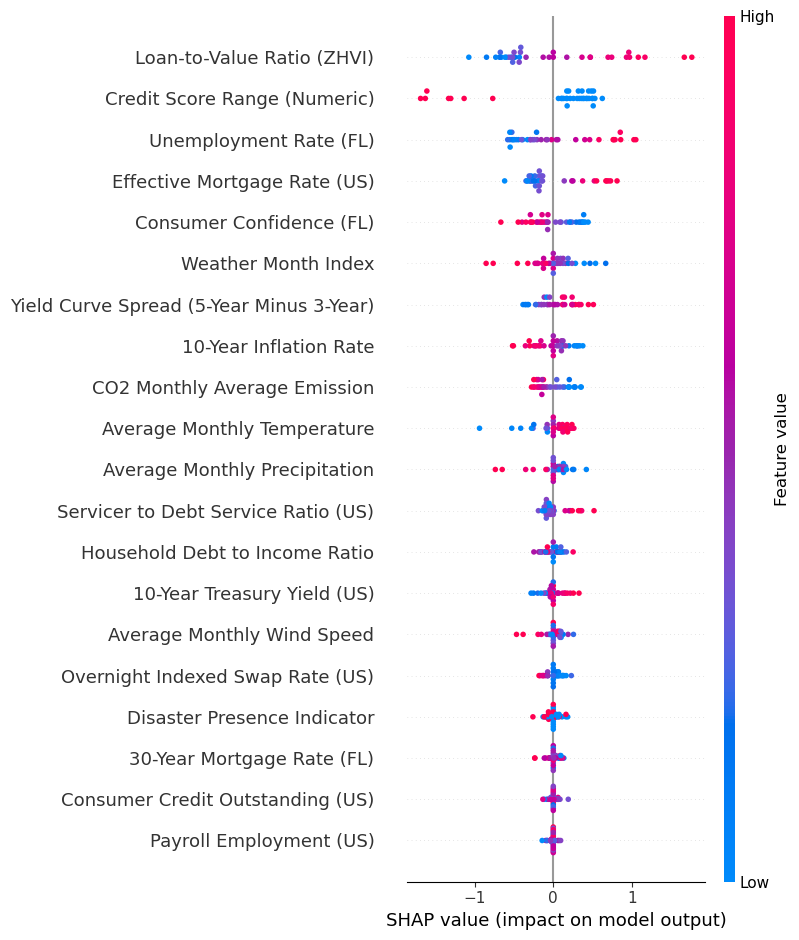

In [25]:
shap_values, shap_base_value, reconstructed_ys = explain_with_shap_kernel(
    model_with_weather,
    X_test_with_weather,
    scaler_with_weather,
    mapped_feature_names,
    sample_size=196,
    seq_length=12
)

In [26]:
def calculate_fidelity(predictions, explained_ys, method='LIME'):
    """
    Calculates the fidelity score by comparing the model predictions to the predictions
    generated by the explanation method.

    Parameters:
    - predictions: numpy array of shape (n,), predicted y values from the model.
    - explained_ys: numpy array of shape (n,), predictions generated by the explanation method.
    - method: str, either 'LIME' or 'SHAP' to indicate which explanation method was used.

    Returns:
    - method_r2: R-squared score between model predictions and explained_ys.
    - method_mse: Mean squared error between model predictions and explained_ys.
    """
    # Calculate the R2 and MSE between the actual model predictions and the explained_ys
    fidelity_r2 = r2_score(predictions, explained_ys)
    fidelity_mse = mean_squared_error(predictions, explained_ys)
    return fidelity_r2, fidelity_mse

In [ ]:
# Step 2: Calculate fidelity
shap_r2, shap_mse = calculate_fidelity(predictions_with_weather, reconstructed_ys, method='SHAP')

In [28]:
shap_r2, shap_mse 

(0.9052134194962278, 0.8523721462658118)

In [29]:
def compute_shap_robustness(model, X, scaler_features, feature_names, shap_values, expected_value, perturbation_factor=0.01, sample_size=100, seq_length=12):
    """
    Compute the robustness of SHAP values by introducing small perturbations to the input data
    and comparing the SHAP values before and after perturbation.

    Parameters:
    - model: Trained LSTM model.
    - X: Original input data (3D array for LSTM).
    - scaler_features: Scaler used to transform features.
    - feature_names: List of feature names.
    - shap_values: Original SHAP values (2D array).
    - expected_value: SHAP base value (expected value).
    - perturbation_factor: Factor used to scale the random noise.
    - sample_size: Number of samples to use for robustness analysis.
    - seq_length: Sequence length used by the LSTM model.

    Returns:
    - robustness_loss: The Mean Squared Error between the original and perturbed SHAP values.
    """
    # Step 1: Select a subset of the data for analysis
    sample_X = X[:sample_size]
    sample_X_2d = sample_X[:, -1, :]  # Use the last time step for each sequence

    # Step 2: Define a prediction function with the correct sequence length
    def predict_fn(data):
        # Reshape data back to 3D to match the LSTM model input
        data_3d = np.array([data] * seq_length).transpose(1, 0, 2)
        return model.predict(data_3d).flatten()

    # Step 3: Recompute SHAP values for the original data subset
    original_explainer = shap.KernelExplainer(predict_fn, sample_X_2d)
    original_shap_values = original_explainer.shap_values(sample_X_2d, nsamples=50)[0]

    # Step 4: Perturb the input data by adding random noise
    noise = np.random.normal(0, perturbation_factor, sample_X_2d.shape)
    perturbed_X_2d = sample_X_2d + noise

    # Step 5: Compute SHAP values for the perturbed data
    perturbed_explainer = shap.KernelExplainer(predict_fn, perturbed_X_2d)
    perturbed_shap_values = perturbed_explainer.shap_values(perturbed_X_2d, nsamples=50)[0]

    # Step 6: Calculate the Mean Squared Error between original and perturbed SHAP values
    robustness_loss = mean_squared_error(original_shap_values, perturbed_shap_values)
    return robustness_loss

In [ ]:
robustness_loss = compute_shap_robustness(
    model_with_weather, X_test_with_weather, scaler_with_weather,
    feature_names, shap_values, shap_base_value, perturbation_factor=0.01, 
    sample_size=50, seq_length=12
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 0/36 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

  0%|          | 0/36 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

In [31]:
print(f"SHAP Fedility loss: {shap_mse }")

SHAP Fedility loss: 0.8523721462658118


In [32]:
print(f"SHAP Robustness Loss: {robustness_loss}")

SHAP Robustness Loss: 0.14174360886766138


In [87]:
y_test_with.shape, predictions_with_weather.shape

((36,), (36, 1))

In [93]:
y_test_with

array([8. , 8.1, 0.6, 2.7, 0.6, 8.5, 8.3, 3.8, 1.3, 1.1, 1.7, 0.5, 3.6,
       0.7, 7.6, 8.4, 6.7, 0.9, 1.7, 5. , 1.6, 1.2, 0.7, 8.2, 8.4, 0.6,
       4.7, 8.1, 0.6, 0.5, 1.2, 5.1, 0.7, 0.9, 3.9, 8.2])

In [75]:
def plot_residuals(actual_y, predicted_y):
    """
    Generate a residual plot with predicted values on the horizontal axis
    and residuals on the vertical axis to assess model adequacy.

    Parameters:
    - actual_y: Array-like of actual target values.
    - predicted_y: Array-like of predicted target values.
    """
    # Compute residuals
    residuals = actual_y - predicted_y

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(predicted_y, residuals, alpha=0.6, edgecolor='k')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

# Example Usage:
# plot_residuals(y_test_with_inverse, predictions_with_weather_inverse)


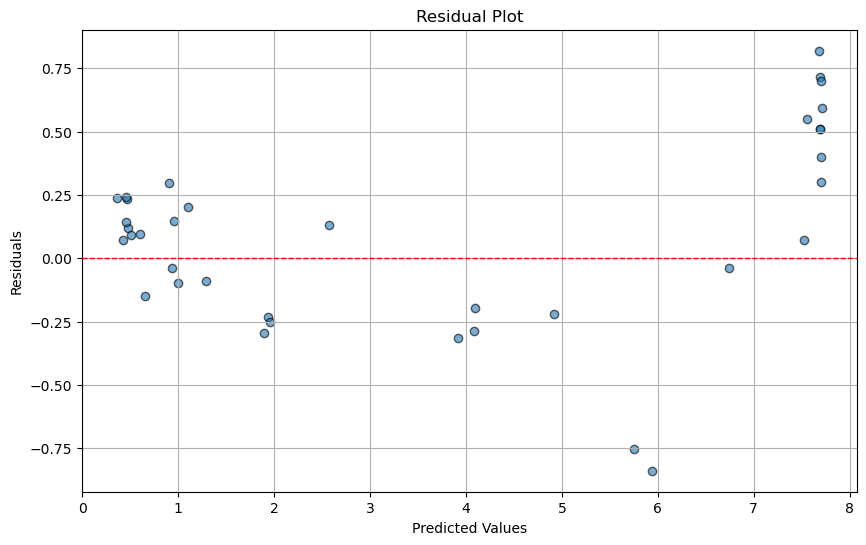

In [91]:
plot_residuals(y_test_with, predictions_with_weather.flatten())

In [99]:
def adf_test(series, significance_level=0.05):
    """
    Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity.

    Parameters:
    - series: pandas Series or 1D array of data to be tested.
    - significance_level: Significance level for the hypothesis test.

    Returns:
    - Dictionary containing the test statistic, p-value, critical values, and stationarity result.
    """
    result = adfuller(series, autolag='AIC')
    test_statistic, p_value, used_lag, n_obs, critical_values, ic_best = result

    is_stationary = p_value < significance_level
    return {
        "Test Statistic": test_statistic,
        "P-Value": p_value,
        "Critical Values": critical_values,
        "Is Stationary": is_stationary
    }


def kpss_test(series, significance_level=0.05, regression='c'):
    """
    Perform the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test to check for stationarity.

    Parameters:
    - series: pandas Series or 1D array of data to be tested.
    - significance_level: Significance level for the hypothesis test.
    - regression: Type of regression ('c' for constant, 'ct' for constant and trend).

    Returns:
    - Dictionary containing the test statistic, p-value, critical values, and stationarity result.
    """
    result = kpss(series, regression=regression, nlags="auto")
    test_statistic, p_value, lags, critical_values = result

    is_stationary = p_value > significance_level
    return {
        "Test Statistic": test_statistic,
        "P-Value": p_value,
        "Critical Values": critical_values,
        "Is Stationary": is_stationary
    }

In [103]:
residuals = y_test_with - predictions_with_weather.flatten()
adf_result = adf_test(residuals)
kpss_result = kpss_test(residuals)

C:\Users\vince\AppData\Local\Temp\ipykernel_27004\683930153.py:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression, nlags="auto")


In [105]:
print("ADF Test Result:", adf_result)


ADF Test Result: {'Test Statistic': -3.4517407319941475, 'P-Value': 0.009316521735639653, 'Critical Values': {'1%': -3.653519805908203, '5%': -2.9572185644531253, '10%': -2.6175881640625}, 'Is Stationary': True}


In [107]:
print("KPSS Test Result:", kpss_result)

KPSS Test Result: {'Test Statistic': 0.17511760140980637, 'P-Value': 0.1, 'Critical Values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, 'Is Stationary': True}
